SAS & HSE, Applied Time Series Forecasitng , Winter 2022 

<font color="blue"> HW #2 </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

<h1 align="center">Organization Info</h1> 

**Дополнительный материал для выполнения дз**:
- Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
- Лукашин Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.

**Оформление дз**: 
- Присылайте выполненное задание в гугл-форму: https://forms.gle/G9e9L3ue3cFhNppf7
- Выполненное дз сохраните в файл Surname_w2022_23_hw2.ipynb, например, ivanov_w2022_23_hw2.ipynb

**Вопросы**:
- Присылайте вопросы в slack в соответствующий канал

**Deadline**: <font color="red"> 10-Jan-2023 11:59:59 pm CET </font>

В случае присланного решения позже дедлайна максимальный бал буде снижен согласно формуле

$$МаксимальныйБалл=\max\bigl(3,max(0,(10-ДнейПослеДедлайна/7))) \bigr).$$
График зависимости максимально возможного балла за ДЗ от просрочки дедлайна приведён ниже: 

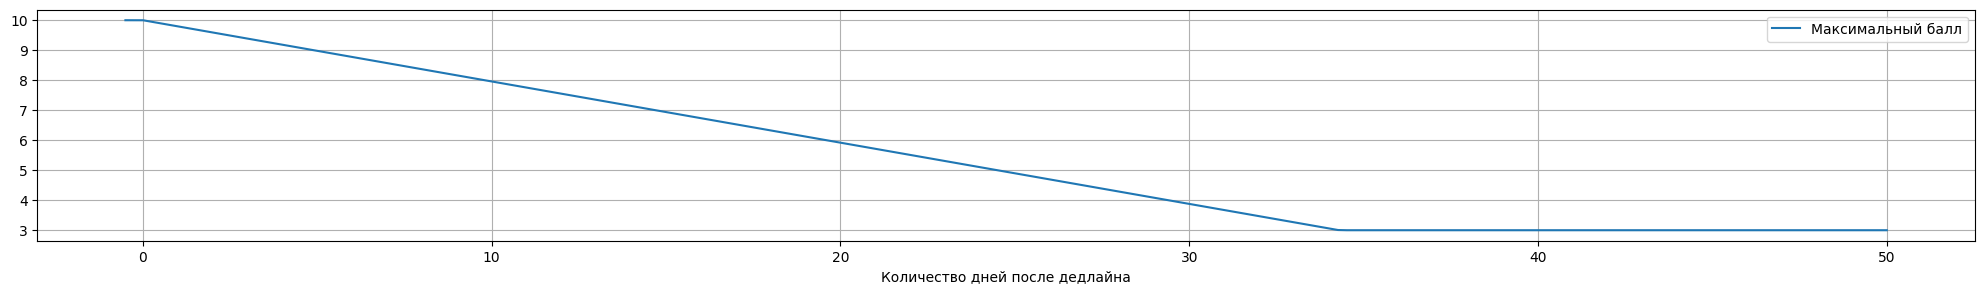

In [187]:
import pandas as pd
import numpy as np
a = 2
ax = pd.DataFrame(data = [[x, min(10, 10*max(0.3, (1-x/49)))] for x in np.linspace(-0.5,50,200)], columns = ['Количество дней после дедлайна', 'Максимальный балл']).set_index('Количество дней после дедлайна').plot(figsize = (25,3), grid = True)

<h1 align="center">Check Questions (5%)</h1> 


**Questions 1: Write down an equation for $y_t$ (in a form $y_t=f\left(y_{t-1}, \ldots,y_{t-n}, \varepsilon_t, \ldots, \varepsilon_{t-m}\right)$)  that corresponds to the following ARIMA models**:
 - 1) ARIMA $(p=0,d=k,q=1)$,
   <br>$y_t=\beta_1\varepsilon_{t-1}/{\bf(1-B)^{k}} + \varepsilon_t$</br>
 - 2) ARIMA $(p=0,d=k+1,q=1)(P=1, D=1, Q=0)_s$,
   <br>$y_t=(\beta_1\varepsilon_{t-1} + \delta_1y_{t-s})/{\bf(1-B)^{k+1}(1-B^s)} + \varepsilon_t$</br>


<h1 align="center"> Practice</h1>

<h2 align="center">  1. Download data for following data sets (15%)</h2>


* 0) Download data
  <span style="color:blue; font-family:'New Times Roman'; font-size:14pt"> 
  
  description of the target ts you can find here  https://docs.google.com/spreadsheets/d/1HwwDZMCVUl-wpdY39TdBBKMwvks9VTe2gIpFtGBu-28/edit#gid=1251818784 </span> sheet "TS" in column O

* 1) plot target ts 
* 2) plot cros-series plot: independent variables and target variable on the same subplot 
* 3) answer the questions: 
    - is there seasonality? If there is seasonality then define period(s) of seasonality.
    - trend?
    - not-stable dispersion? 
* 4) define the proper list of transformations in order to make thet ts stationary (find optimal lambda in Box-Cox tranformation, if needed). 

In [188]:
# start with this code
from utils import InitExponentialSmoothing, build_forecast, plot_ts_forecast
from utils import qualityMAPE 
import numpy as np
from scipy import stats
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
import pandas as pd
import math
import pandas.tseries.offsets as ofs
import warnings as w
from utils import qualityMAPE, SimpleExponentialSmoothing
from matplotlib import gridspec
import statsmodels.api as sm
from statsmodels.tsa import stattools
import seaborn as sns

%matplotlib inline

df = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/energy_consumption.csv', parse_dates=['Date'])
ts_original = df[df.id == 5].drop(columns='id').set_index('Date')['2010-07-01':'2013-07 -01']

# Drop columns with NaN-s
ts_original = ts_original.drop(columns=[f'Temp{i+3}' for i in range(7)], errors='ignore')
ts_original = ts_original.drop(columns=[f'Temp{i+1}_South_Less' for i in range(4)], errors='ignore')
ts_original = ts_original.drop(columns=[f'Temp{i+1}_South_Gr' for i in range(4)], errors='ignore')

ts_original.describe()

,EnergyConsumption,Temp1,Temp2,Saturday,Sunday
count,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000
mean,144465.207995,5.055697,5.795898,0.138560,0.182315
std,17692.822865,13.589146,13.591426,0.345644,0.386280
min,111045.255000,-25.000000,-25.300000,0.000000,0.000000
25%,130113.092000,-6.000000,-5.300000,0.000000,0.000000
50%,142728.406000,5.900000,7.000000,0.000000,0.000000
75%,159734.610000,17.000000,17.600000,0.000000,0.000000
max,183084.398000,31.500000,32.000000,1.000000,1.000000


<AxesSubplot: xlabel='Date'>

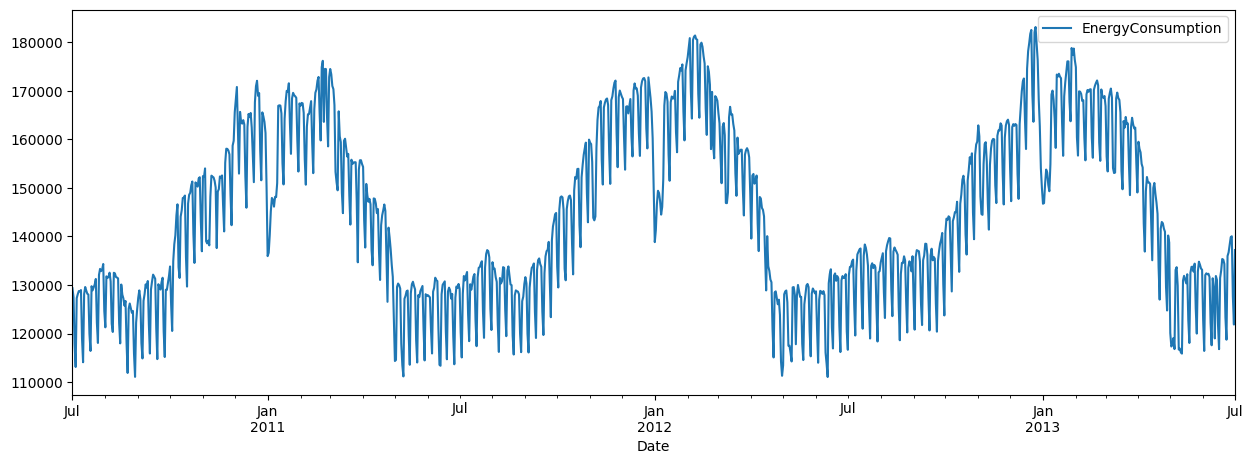

In [189]:
# 1. plot target ts
ts.plot(figsize=(15,5))

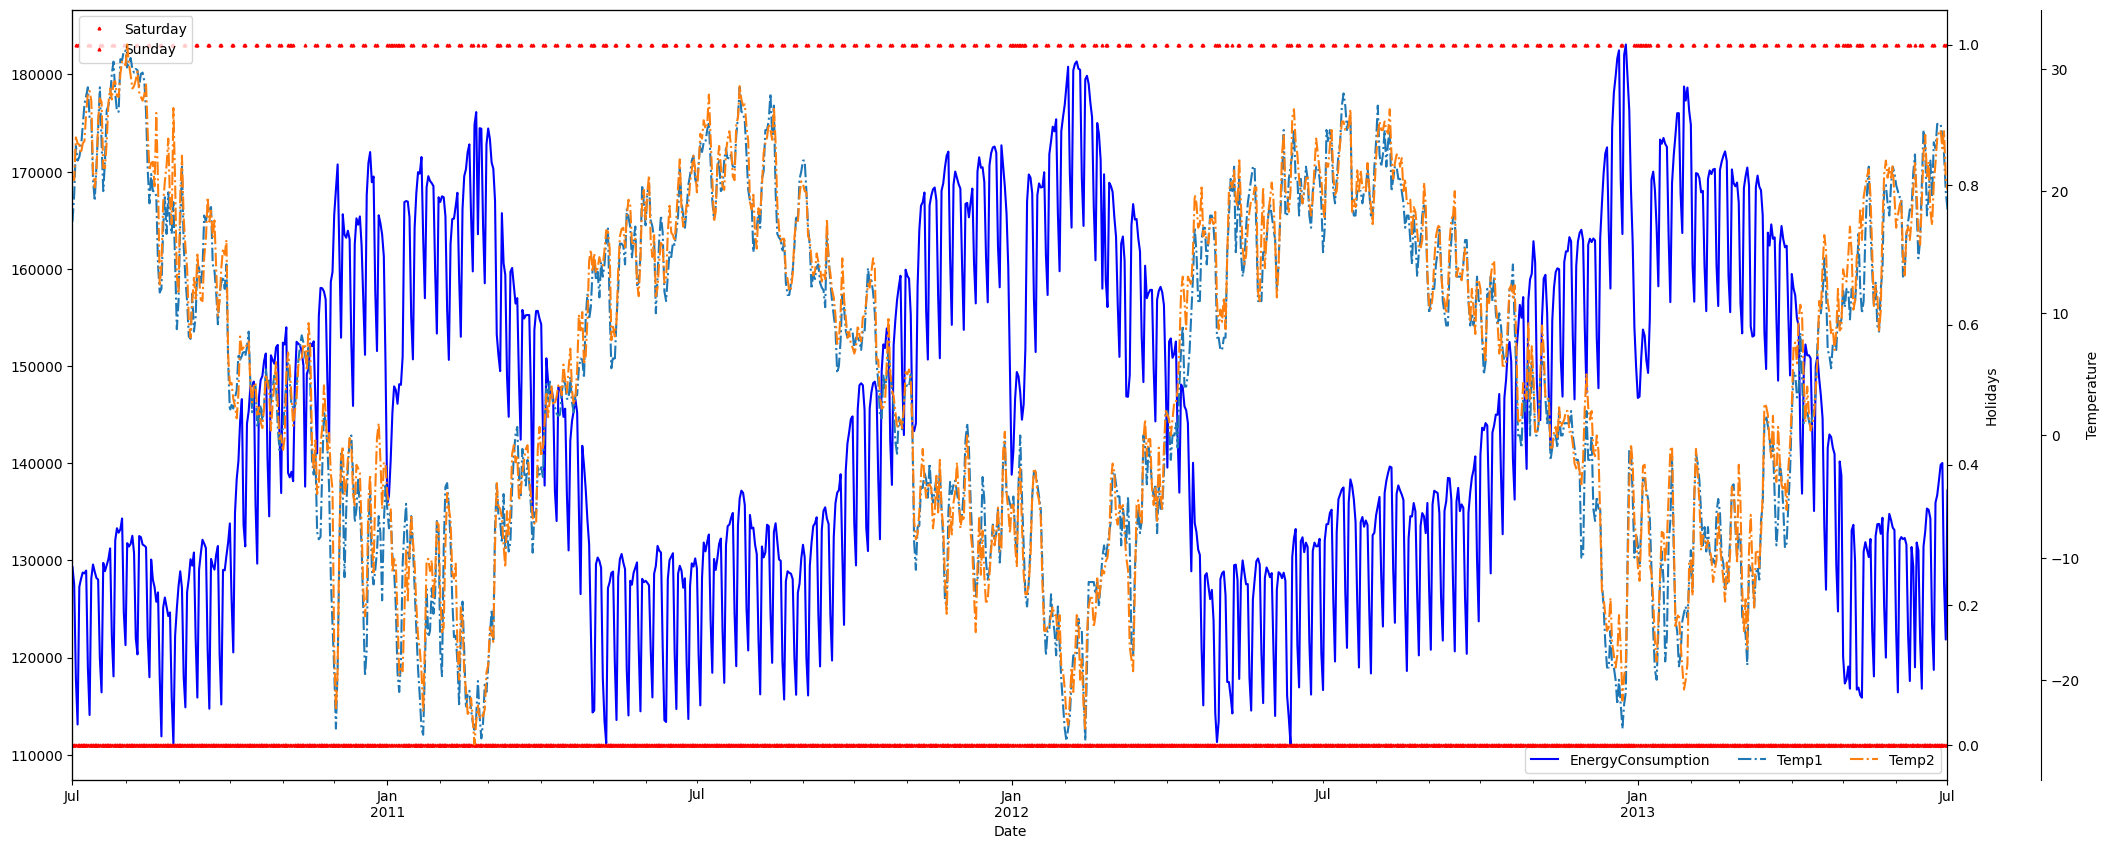

In [190]:
# 2. plot cros-series plot: independent variables and target variable on the same subplot

fig, ax = plt.subplots(figsize=[30,10])
ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
ax3.set_ylabel('Temperature')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.05))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.75)

ts_to_plot = ts_original
ts_to_plot['EnergyConsumption'].plot(ax = ax,  style='b-')
ts_to_plot[['Saturday', 'Sunday']].plot(ax = ax2, style='r', marker = '^', markersize = 2.0, linewidth=0.0)

for col in ts_original.columns:
    if col.startswith('Temp'):
        style = '--' if col.endswith('Less') else '-.'
        ts_to_plot[col].plot(ax = ax3,  style=style)

lines = ax.get_lines() + ax3.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='lower right', ncol=3)
ax2.legend(loc='upper left')
plt.show()

*Is there seasonality? If there is seasonality then define period(s) of seasonality.*

Yes, there's a seasonality. The seasonality can be clearly inferred from the chart above. There are two periods: 7 and 365 days.

*Is there a trend?*

Yes, there's a slow increasing trend.

*Not-stable dispersion?*

No,  variance does not change over time (again, from the visible representation) 

*Define the proper list of transformations in order to make thet ts stationary*

We might need to perform trend and seasonality transformations. Let's run a series of tests to check if our time series is stationary in its original form.

In [191]:
# ADF
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    X = series.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
adf_test(ts)

ADF Statistic: -2.328800
p-value: 0.162847
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


### ADF analysis

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -2.328800 is more than the value of -3.436 at 1%.

This suggests that we can not reject the null hypothesis with a significance level of less than 1% => if we can not reject the null hypothesis then the process has unit root, and in turn  the time series is not stationary.

Next, let's use KPSS test:

In [192]:
#KPSS
from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(ts)

KPSS Statistic: 0.24520468871038406
p-value: 0.1
num lags: 19
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(



### KPSS analysis

Contrary to ADF, KPSS indicates that the time series has a stationary nature. To satisfy both tests, I will perform trend and seasonal differencing in the next task. Then repeat tests on the transformed time series.

<h2 align="center">2. Fit ARIMA Model (50%) </h2>

**I. Build ARIMA forecast manually ** 

You should follow the next scheme:

 * 0) split the ts to two parts: first 80% of timestamps (ts1) and the last 20% of timestamps (ts2)   
 * 1) apply transformation to make the ts1 stationary;
 * 2) define exogenous variables and apply the transformations to them, if needed
 * 3) train simple ARIMA (0, 0, 0) with exogenous variables only, endog = 1) exog = 2);
 * 4) plot ACF/PACF for resifuals of the simple ARIMA(0, 0, 0) in order to understand which $p, P, q, Q$ can be used; define set of candidate parameters for ARMA (for the train TS);
 * 5) select the best parameters of the ARIMA models iteratively: 
    * While there are significant ACF/PACF lags and ARIMA can be trained
      - change only one of 6 ARIMA parameters (p, d, q, P, D, Q) 
      - compare the new model with the previous best model based on  AIC|BIC|HQIC
      - plot ACF/PACF of the best model

  **Note**: there is no goal to minimize AIC|BIC|HQIC, the goal is to exclude all significant autocorrelations from ACF/PACF.

* 6) Check  the best model residuals for 
    - unbiasedness, 
    - stationarity
    - non-autocorrelation
    - white noise hypothesis

    If all tests fail you need to review your choice.
* 7) Run analysis of the regression coafficients
    
    - if there are some insignificant regressors that can be eliminated, please exclude them from the model.

* 8) build forecast for the ts2 (you need to transform exogenous variables if you applied Box-Cox tranformations in step 1); plot this forecast on the same plot with original ts2 data
* 9) Calculate loss MAPE of your forecast. Does the forecast look appropriate?

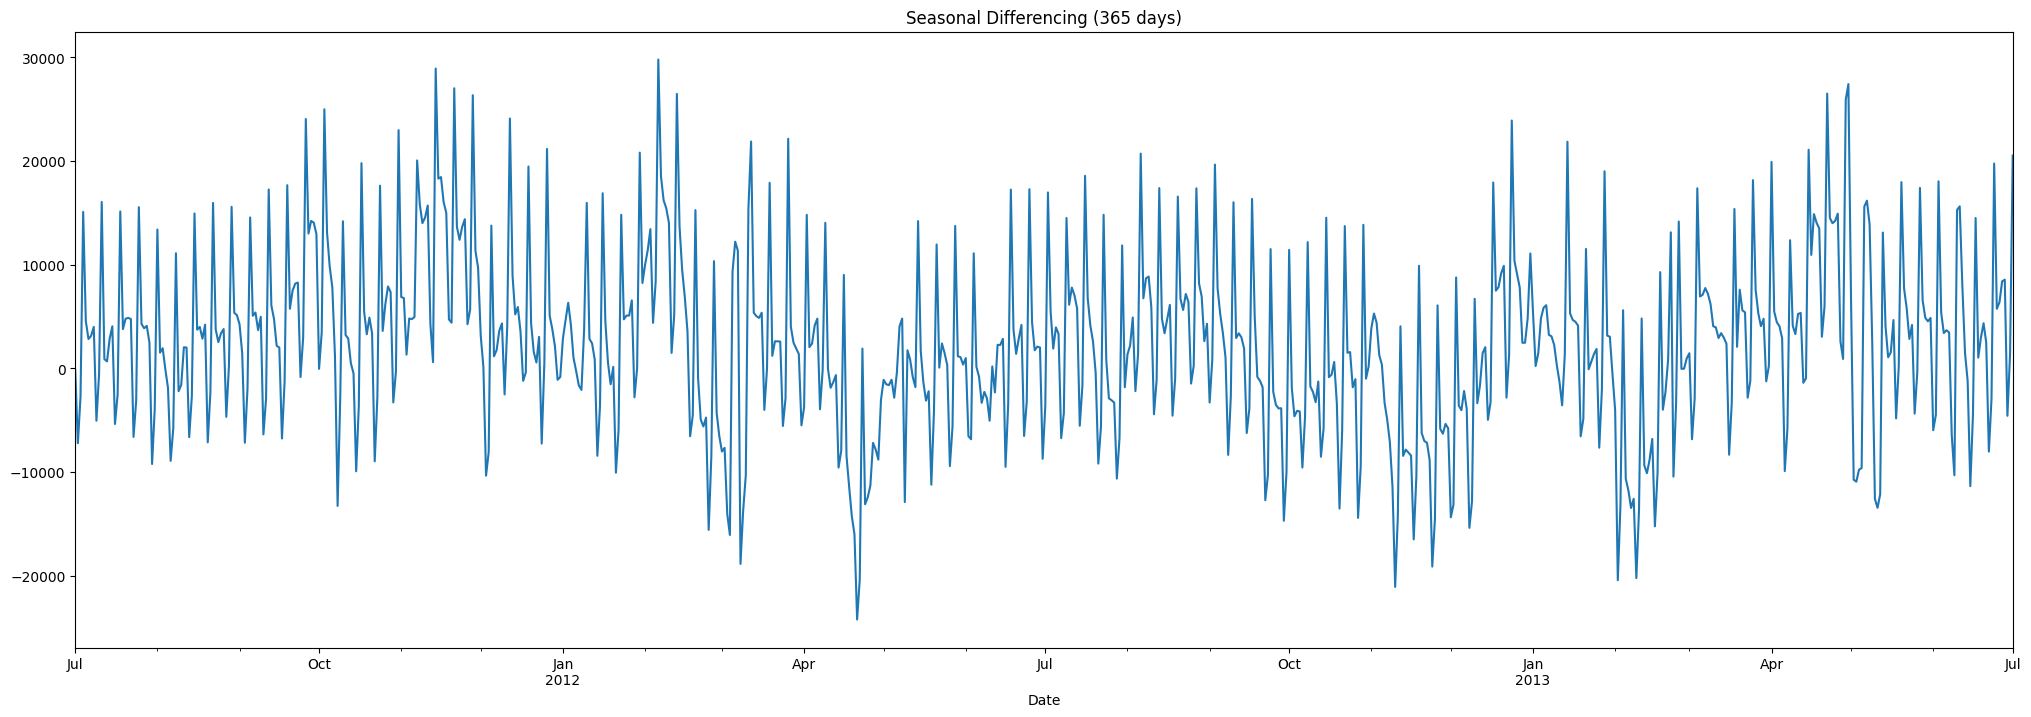

In [193]:
# 0. split the ts to two parts: first 80% of timestamps (ts1) and the last 20% of timestamps (ts2)
split_idx = int(len(ts_original) * 0.8)
ts1 = ts_original.iloc[:split_idx]
ts2 = ts_original.iloc[split_idx:]

# 1. apply transformation to make the ts1 stationary

# seasonal differencing 1
s = 365
ts_sdiff = (ts_original - ts_original.shift(s)).iloc[s:]
ts_sdiff['EnergyConsumption']['2010-07-01':'2013-07-01'].plot(figsize=(25,8))
plt.title("Seasonal Differencing (365 days)")
plt.show()


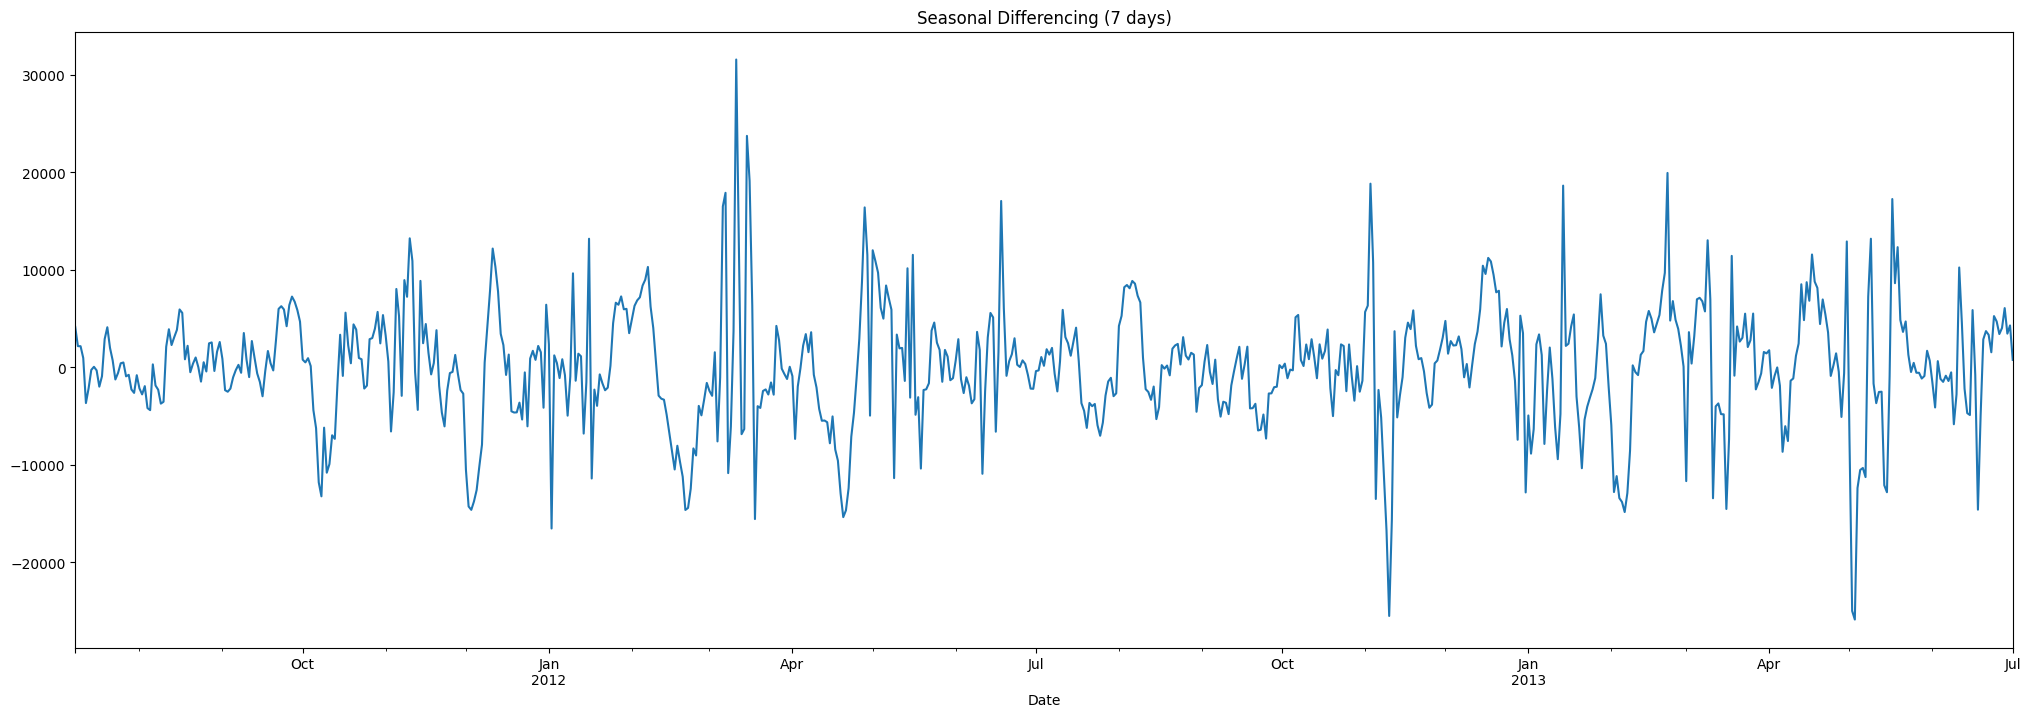

In [194]:
# seasonal differencing 2
s = 7
ts_ssdiff = (ts_sdiff - ts_sdiff.shift(s)).iloc[s:]
ts_ssdiff['EnergyConsumption']['2010-07-01':'2013-07 -01'].plot(figsize=(25,8))
plt.title("Seasonal Differencing (7 days)")
plt.show()

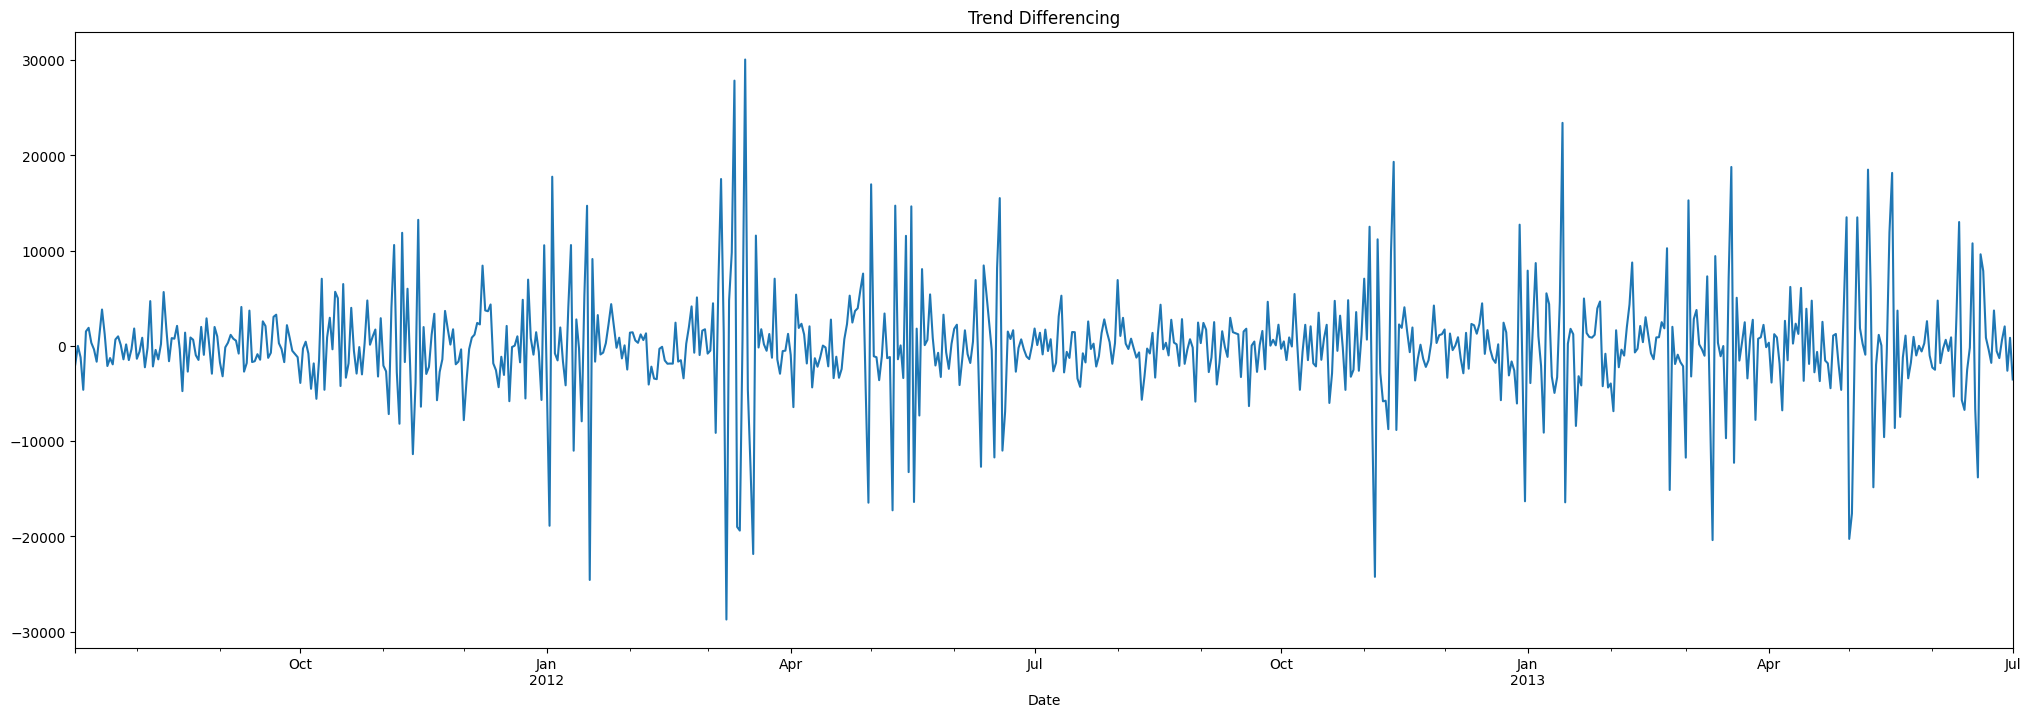

In [195]:
# trend differencing
ts_ssdiff_tdiff = (ts_ssdiff - ts_ssdiff.shift(1)).iloc[1:]
ts_ssdiff_tdiff['EnergyConsumption']['2010-07-01':'2013-07 -01'].plot(figsize=(25,8))
plt.title("Trend Differencing")
plt.show()

In [196]:
kpss_test(ts_ssdiff_tdiff['EnergyConsumption'])

KPSS Statistic: 0.018454074114991805
p-value: 0.1
num lags: 23
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [197]:

adf_test(ts_ssdiff_tdiff['EnergyConsumption'])

ADF Statistic: -9.672073
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


### Analysis

After performing seasonal and trend transformations, we satisifed both ADF and KPSS tests. Hence, the time series is now in a stationary form and we can use it with ARIMA.

In [198]:
# 3. train simple ARIMA (0, 0, 0) with exogenous variables only, endog = 1) exog = 2);

# we ca skip exog parameter here because our time series was not transformed to become stationary
ts_ssdiff_tdiff_1 = ts_ssdiff_tdiff[:-len(ts2)]
endog = ts_ssdiff_tdiff_1['EnergyConsumption']
exogs = ts_ssdiff_tdiff_1.drop(columns=['EnergyConsumption'])
arima_order_000 = sm.tsa.ARIMA(endog=endog, order=[0,0,0], exog=exogs).fit()
print(arima_order_000.summary())

                               SARIMAX Results                                
Dep. Variable:      EnergyConsumption   No. Observations:                  504
Model:                          ARIMA   Log Likelihood               -4789.913
Date:                Tue, 17 Jan 2023   AIC                           9591.825
Time:                        14:22:21   BIC                           9617.161
Sample:                    07-09-2011   HQIC                          9601.764
                         - 11-23-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4507    149.751     -0.043      0.966    -299.958     287.056
Temp1        -92.3164     48.910     -1.887      0.059    -188.178       3.545
Temp2          9.9519     45.544      0.219      0.8

C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


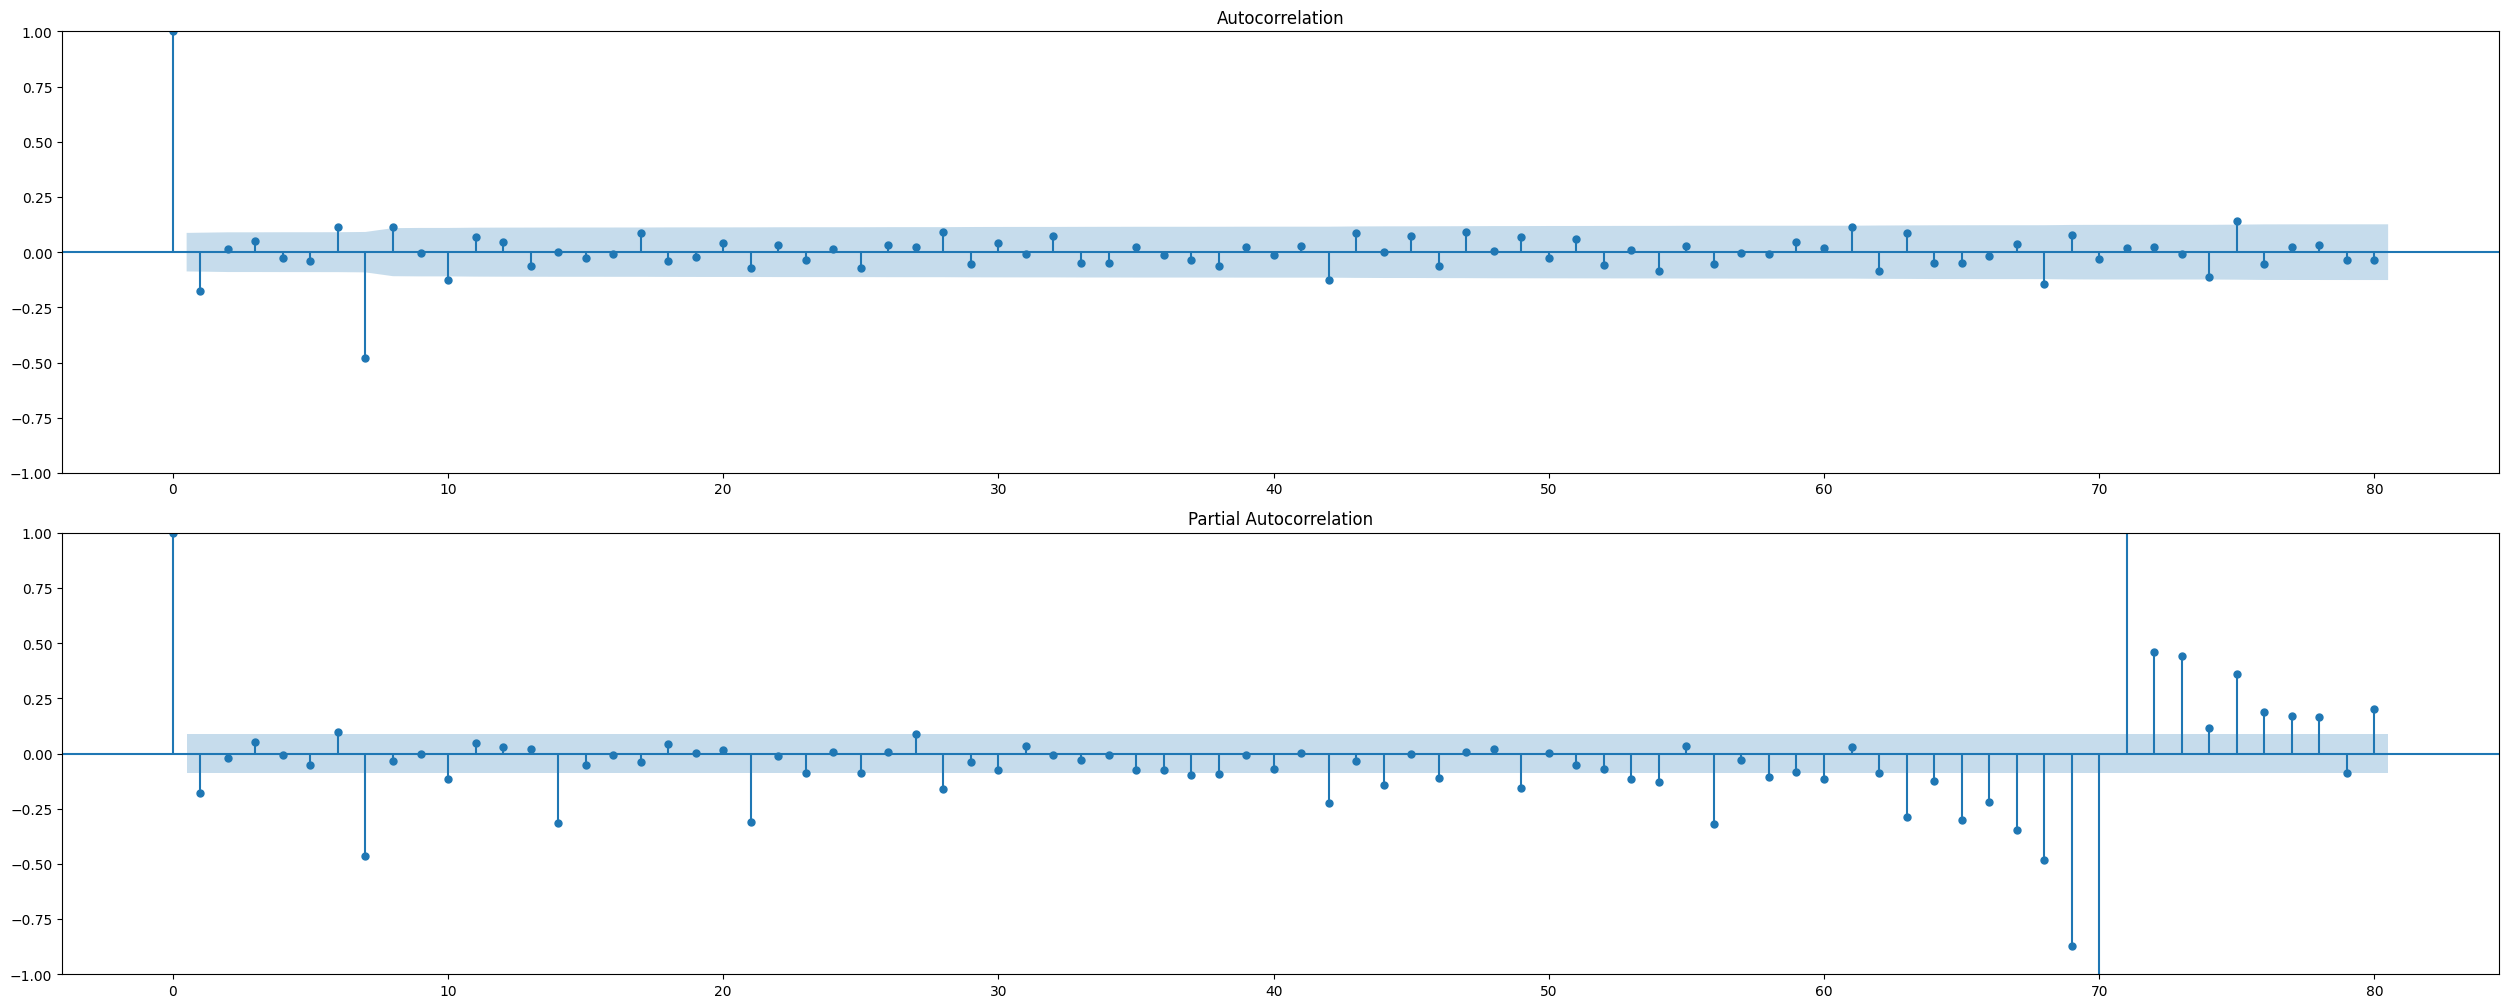

In [199]:
# 4. plot ACF/PACF for resifuals of the simple ARIMA(0, 0, 0) in order to understand which $p, P, q, Q$ can be used; define set of candidate parameters for ARMA (for the train TS)

def plot_acf_pacf(model, lags=365):
    fig = plt.figure(figsize=[25,10])
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(model.resid.values.squeeze(), lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(model.resid.values.squeeze(), lags=lags, ax=ax2)
    
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) # this line fixes matplotlib display bug: https://github.com/matplotlib/matplotlib/issues/14984
    
plot_acf_pacf(arima_order_000, lags=80)

Analysis of ACF and PACF for ARIMA(0,0,0) suggests the following parameter candidate values:
* q = {1,6}
* Q = {1}
* p = {1,6}
* P = {1,2,3,...}

C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                 
Dep. Variable:         EnergyConsumption   No. Observations:                  504
Model:             SARIMAX(0, 0, [1], 7)   Log Likelihood               -4648.624
Date:                   Tue, 17 Jan 2023   AIC                           9309.249
Time:                           14:22:22   BIC                           9334.584
Sample:                       07-09-2011   HQIC                          9319.187
                            - 11-23-2012                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp1        -78.9405     43.099     -1.832      0.067    -163.413       5.532
Temp2         23.8775     42.402      0.563      0.573     -59.230     106.985
Saturday   -7637.0704   1355

C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


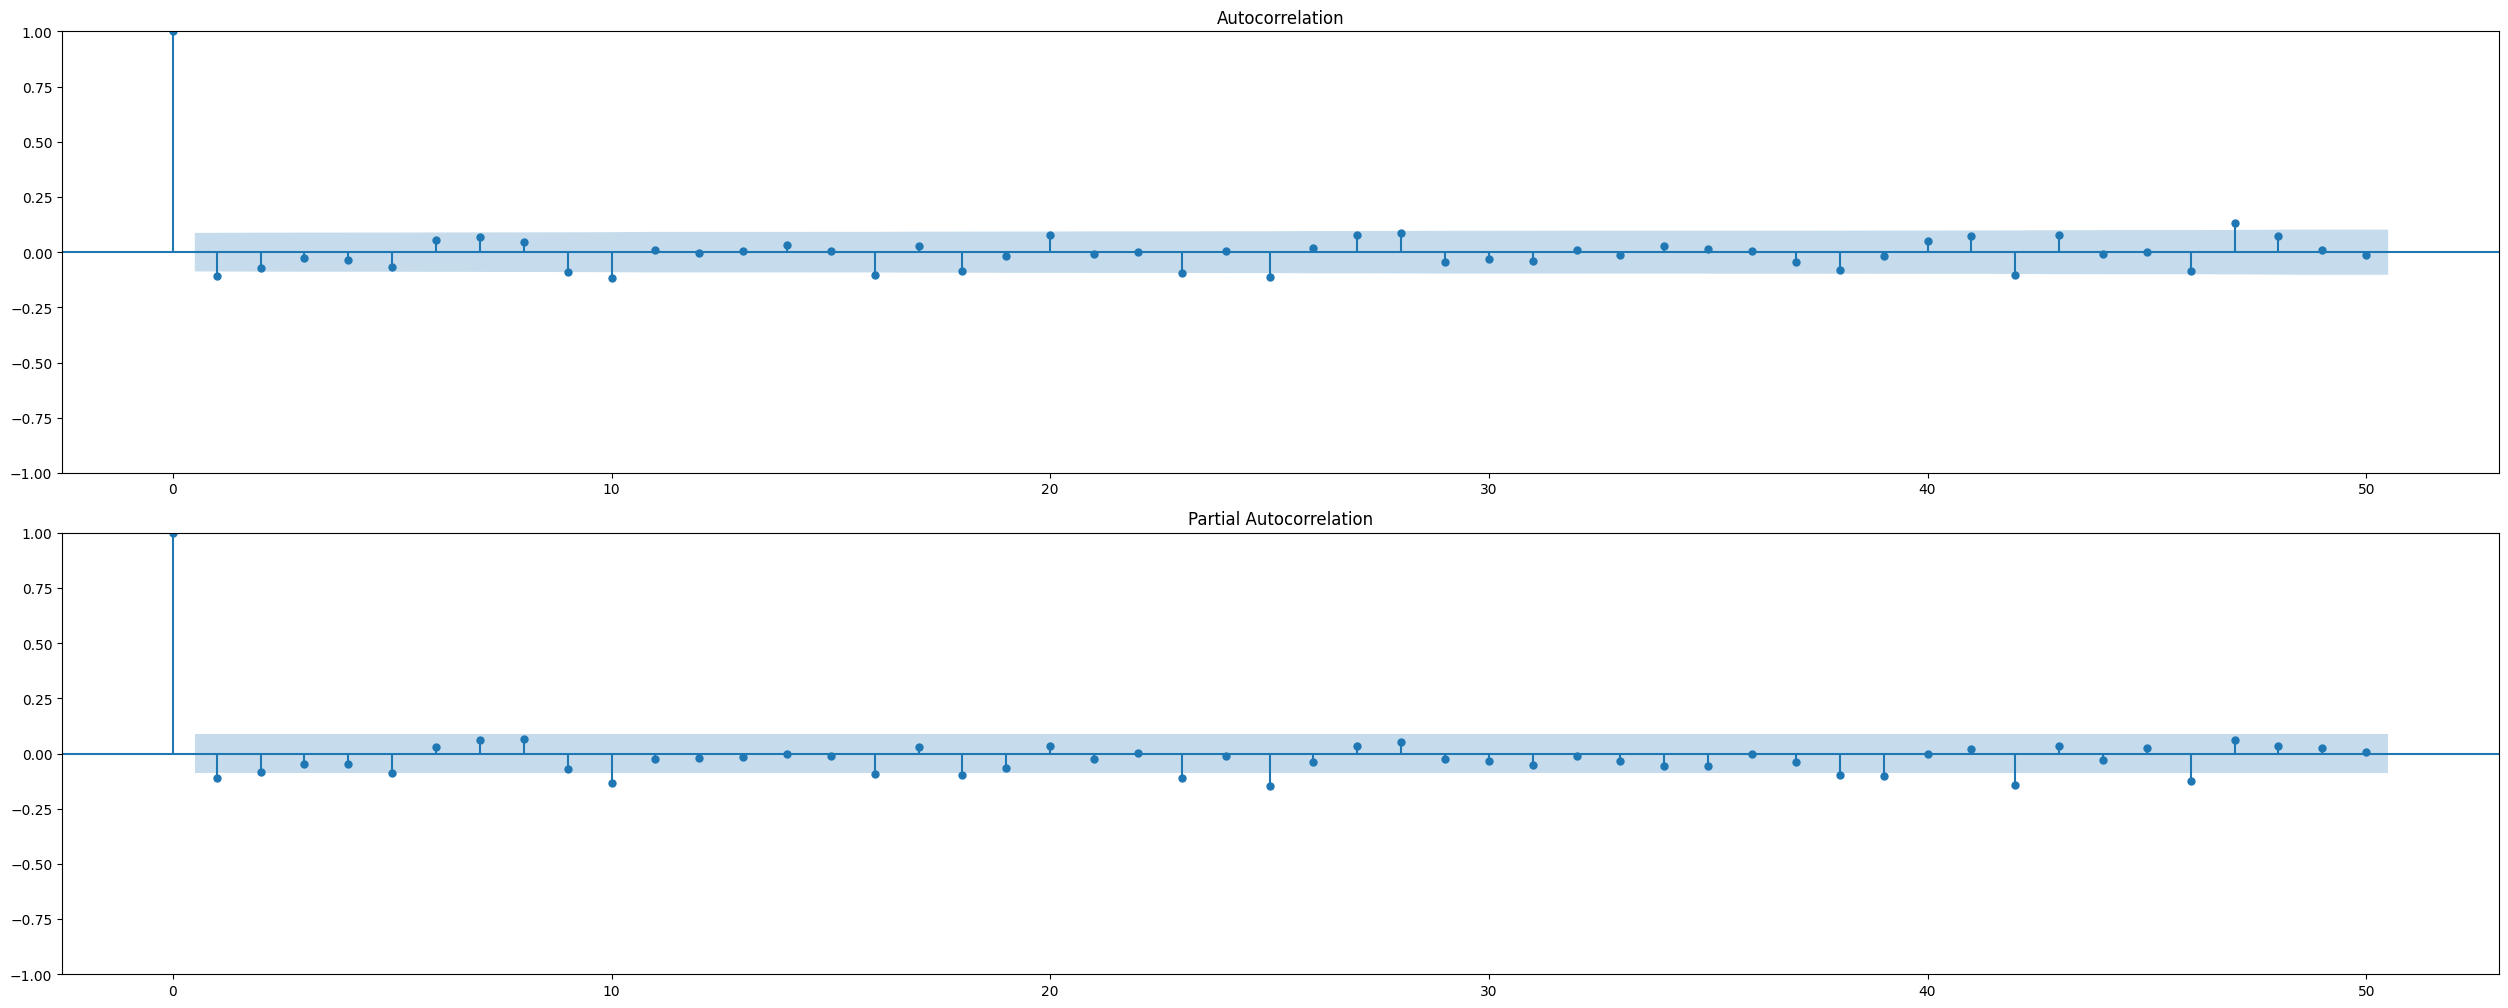

In [200]:
# 5. Select the best parameters of the ARIMA models iteratively.

# Step 1
arima_order_000_001 = sm.tsa.SARIMAX(endog=endog, order=[0,0,0], seasonal_order=[0,0,1,7], exog=exogs).fit()
print(arima_order_000_001.summary())
plot_acf_pacf(arima_order_000_001, lags=50)

All information critera for ARIMA(0,0,0)x(0,0,1,7) model are smaller than for the previous ARIMA(0,0,0) model. This happens apparently due to excluding many correlations at the cost of increasing model complexity very slightly.

Now, seasonality with period 7 seems to be excluded from ACF/PACF. Let's exclude lags 1 and 6.

C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                        SARIMAX Results                                         
Dep. Variable:                        EnergyConsumption   No. Observations:                  504
Model:             SARIMAX([1, 6], 0, 0)x(0, 0, [1], 7)   Log Likelihood               -4644.970
Date:                                  Tue, 17 Jan 2023   AIC                           9305.939
Time:                                          14:22:23   BIC                           9339.720
Sample:                                      07-09-2011   HQIC                          9319.190
                                           - 11-23-2012                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp1        -79.2088     43.738     -1.811      0.070    -164.933

C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


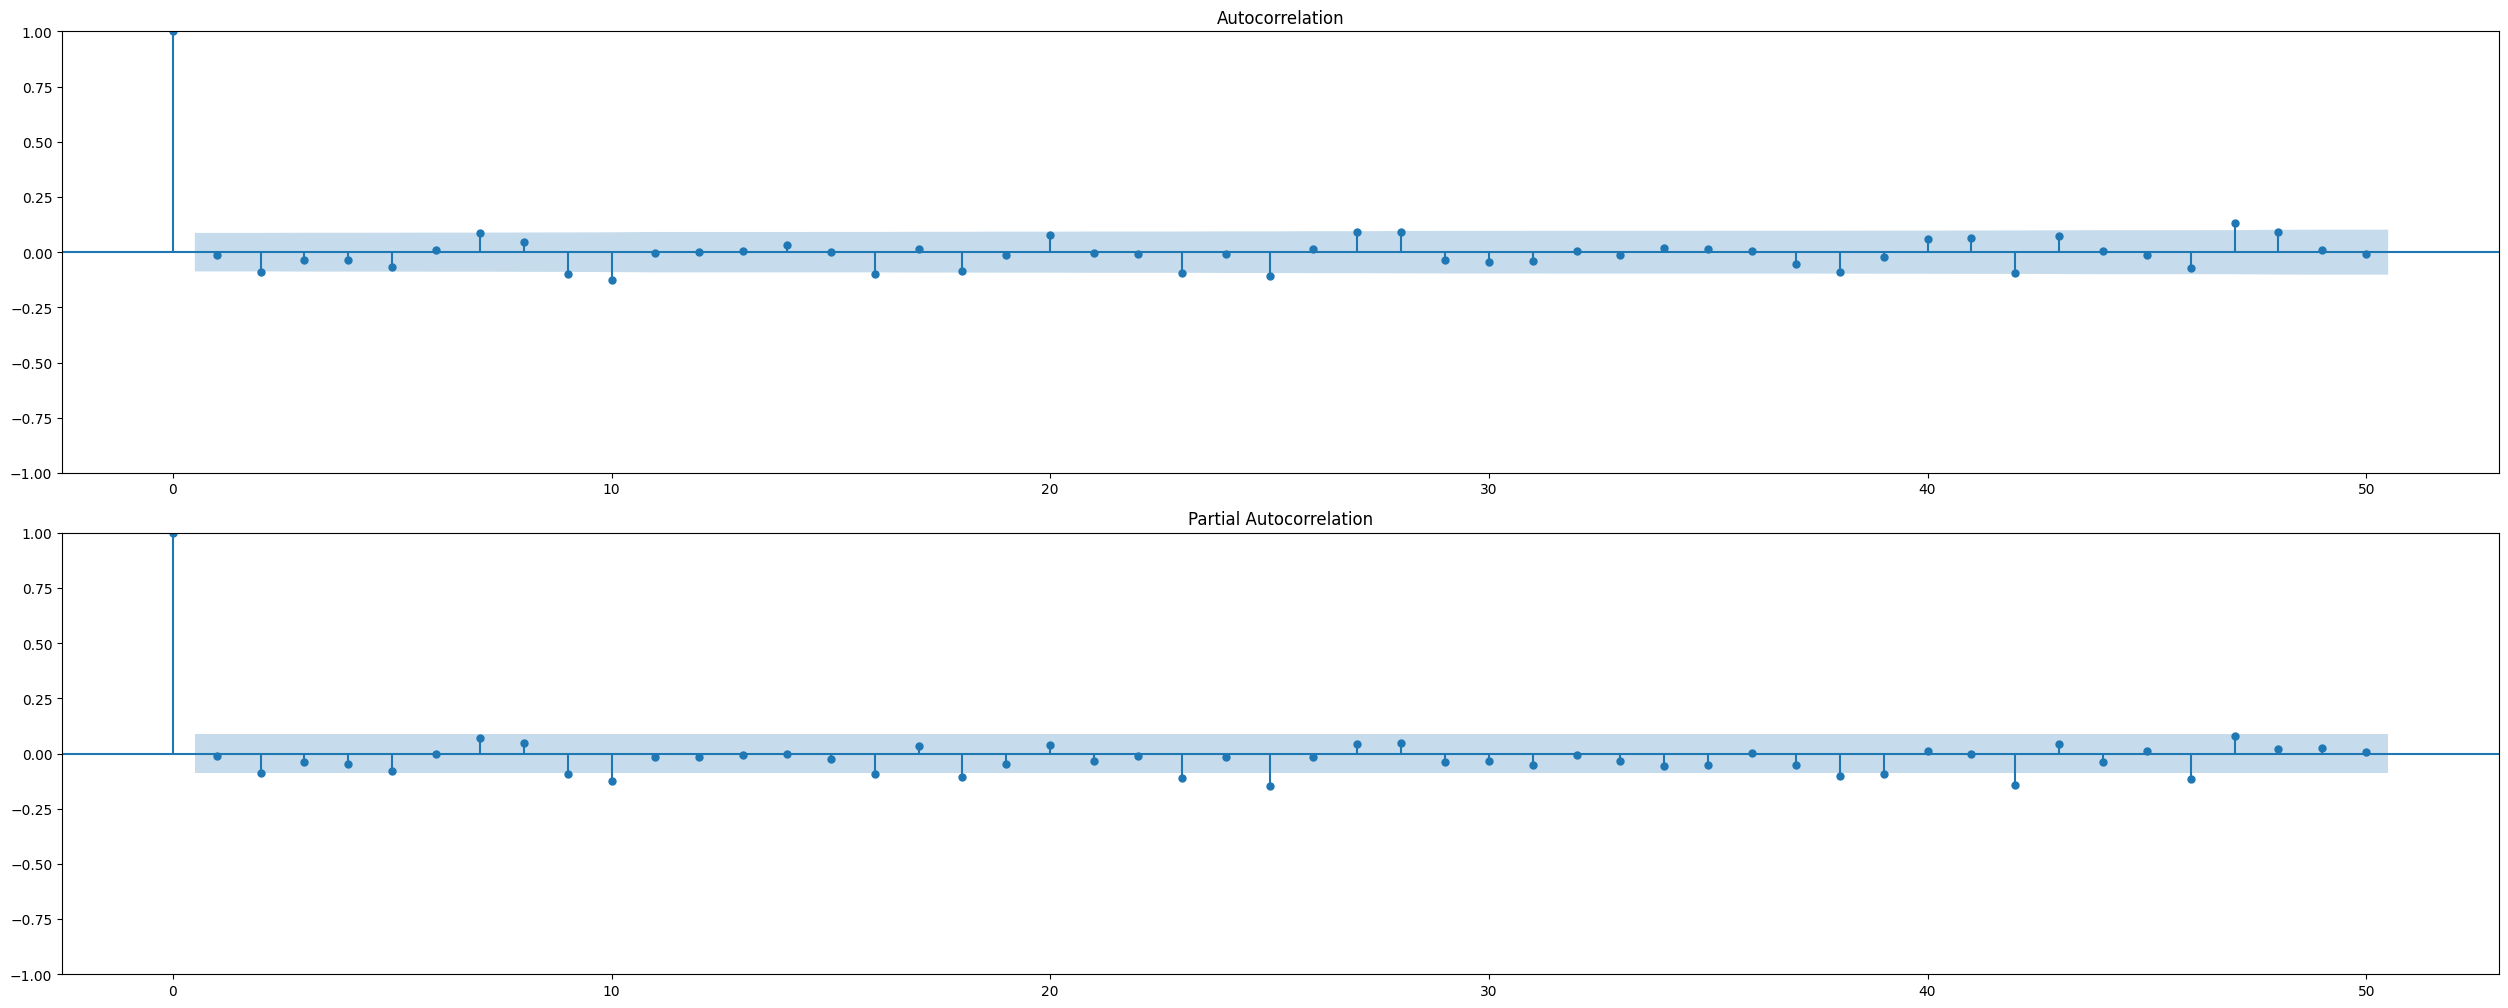

In [201]:
# We use only lags 1 and 6 in order to make ARIMA a bit simpler

# Step 2
arima_order_600_001 = sm.tsa.SARIMAX(endog=endog, order=[(1,6),0,0], seasonal_order=[0,0,1,7], exog=exogs).fit()
print(arima_order_600_001.summary())
plot_acf_pacf(arima_order_600_001, lags=50)

For ARIMA(6,0,0)x(0,0,1,7) vs. ARIMA(0,0,0)x(0,0,1,7), AIC is slightly smaller, BIC is higher, and HQIC is the same. There are still some significant lags on ACF / PACF plots. Let's add AR component for seasonality.

C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                          SARIMAX Results                                          
Dep. Variable:                           EnergyConsumption   No. Observations:                  504
Model:             SARIMAX([1, 2, 6], 0, 0)x(1, 0, [1], 7)   Log Likelihood               -4641.270
Date:                                     Tue, 17 Jan 2023   AIC                           9302.541
Time:                                             14:22:24   BIC                           9344.766
Sample:                                         07-09-2011   HQIC                          9319.104
                                              - 11-23-2012                                         
Covariance Type:                                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp1        -87.8227     45.867     -1.91

C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


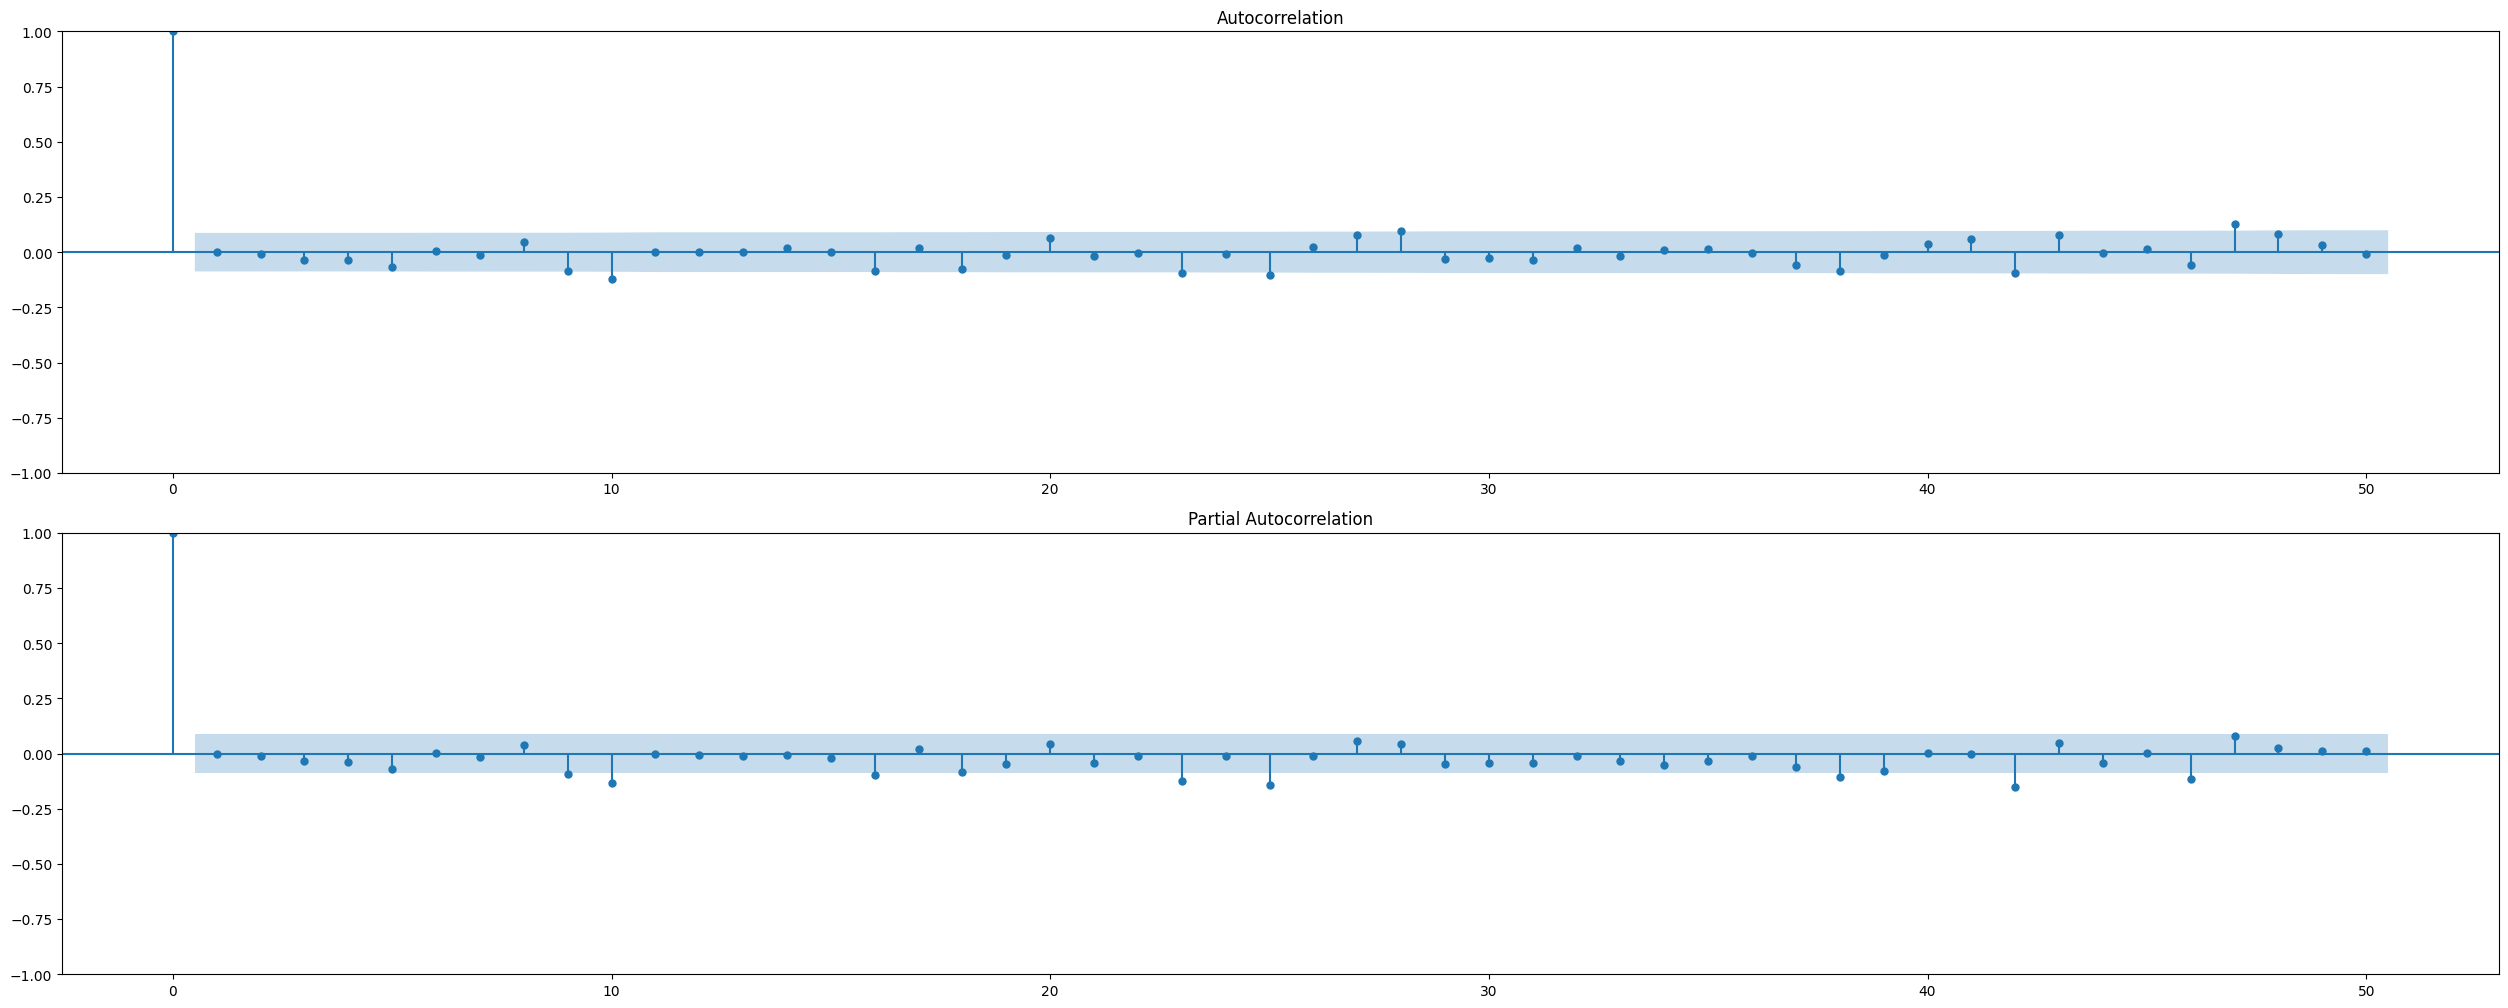

In [202]:
# train ARIMA(6,0,0)x(1,0,1,7)

# Step 3
arima_order_600_101 = sm.tsa.SARIMAX(endog=endog, order=[(1,2,6),0,0], seasonal_order=[1,0,1,7], exog=exogs).fit()
print(arima_order_600_101.summary())
plot_acf_pacf(arima_order_600_101, lags=50)

C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                            SARIMAX Results                                             
Dep. Variable:                                EnergyConsumption   No. Observations:                  504
Model:             SARIMAX([1, 2, 6], 0, [1, 6])x(1, 0, [1], 7)   Log Likelihood                -246.434
Date:                                          Tue, 17 Jan 2023   AIC                            516.867
Time:                                                  14:23:12   BIC                            567.538
Sample:                                              07-09-2011   HQIC                           536.744
                                                   - 11-23-2012                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Te

C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


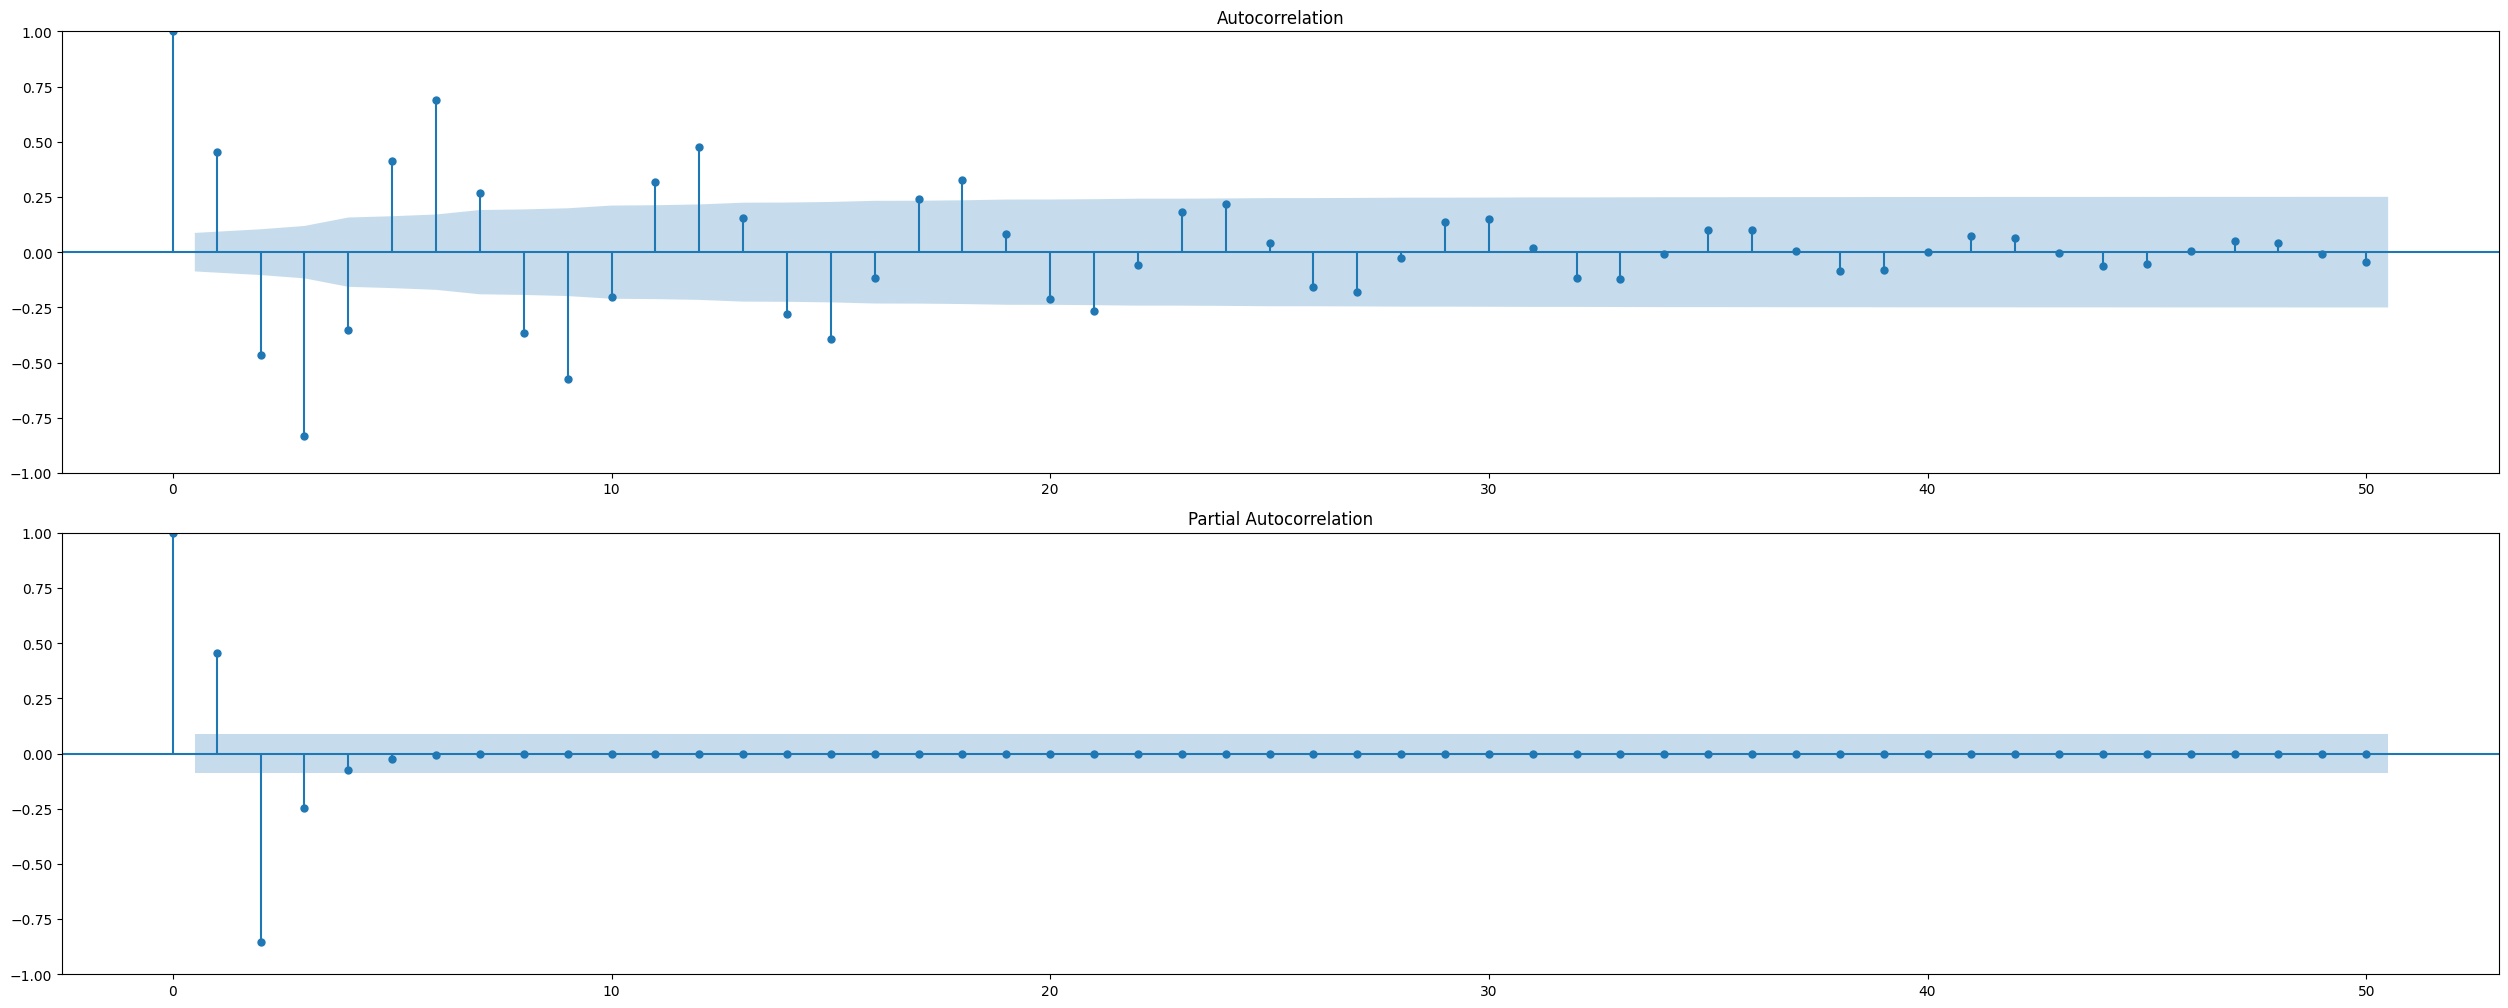

In [203]:
# train ARIMA(6,0,6)x(1,0,1,7)

# Step 4
arima_order_606_101 = sm.tsa.SARIMAX(endog=endog, order=[(1,2,6),0,(1,6)], seasonal_order=[1,0,1,7], exog=exogs).fit()
print(arima_order_606_101.summary())
plot_acf_pacf(arima_order_606_101, lags=50)

The last model ARIMA(6,0,6)x(1,0,1,7) doesn't seem to be the best one in terms of excluding / reducing significant correlations on ACF / PACF plots. So, I propose to pick ARIMA(6,0,0)x(1,0,1,7) as our "best model."

[]

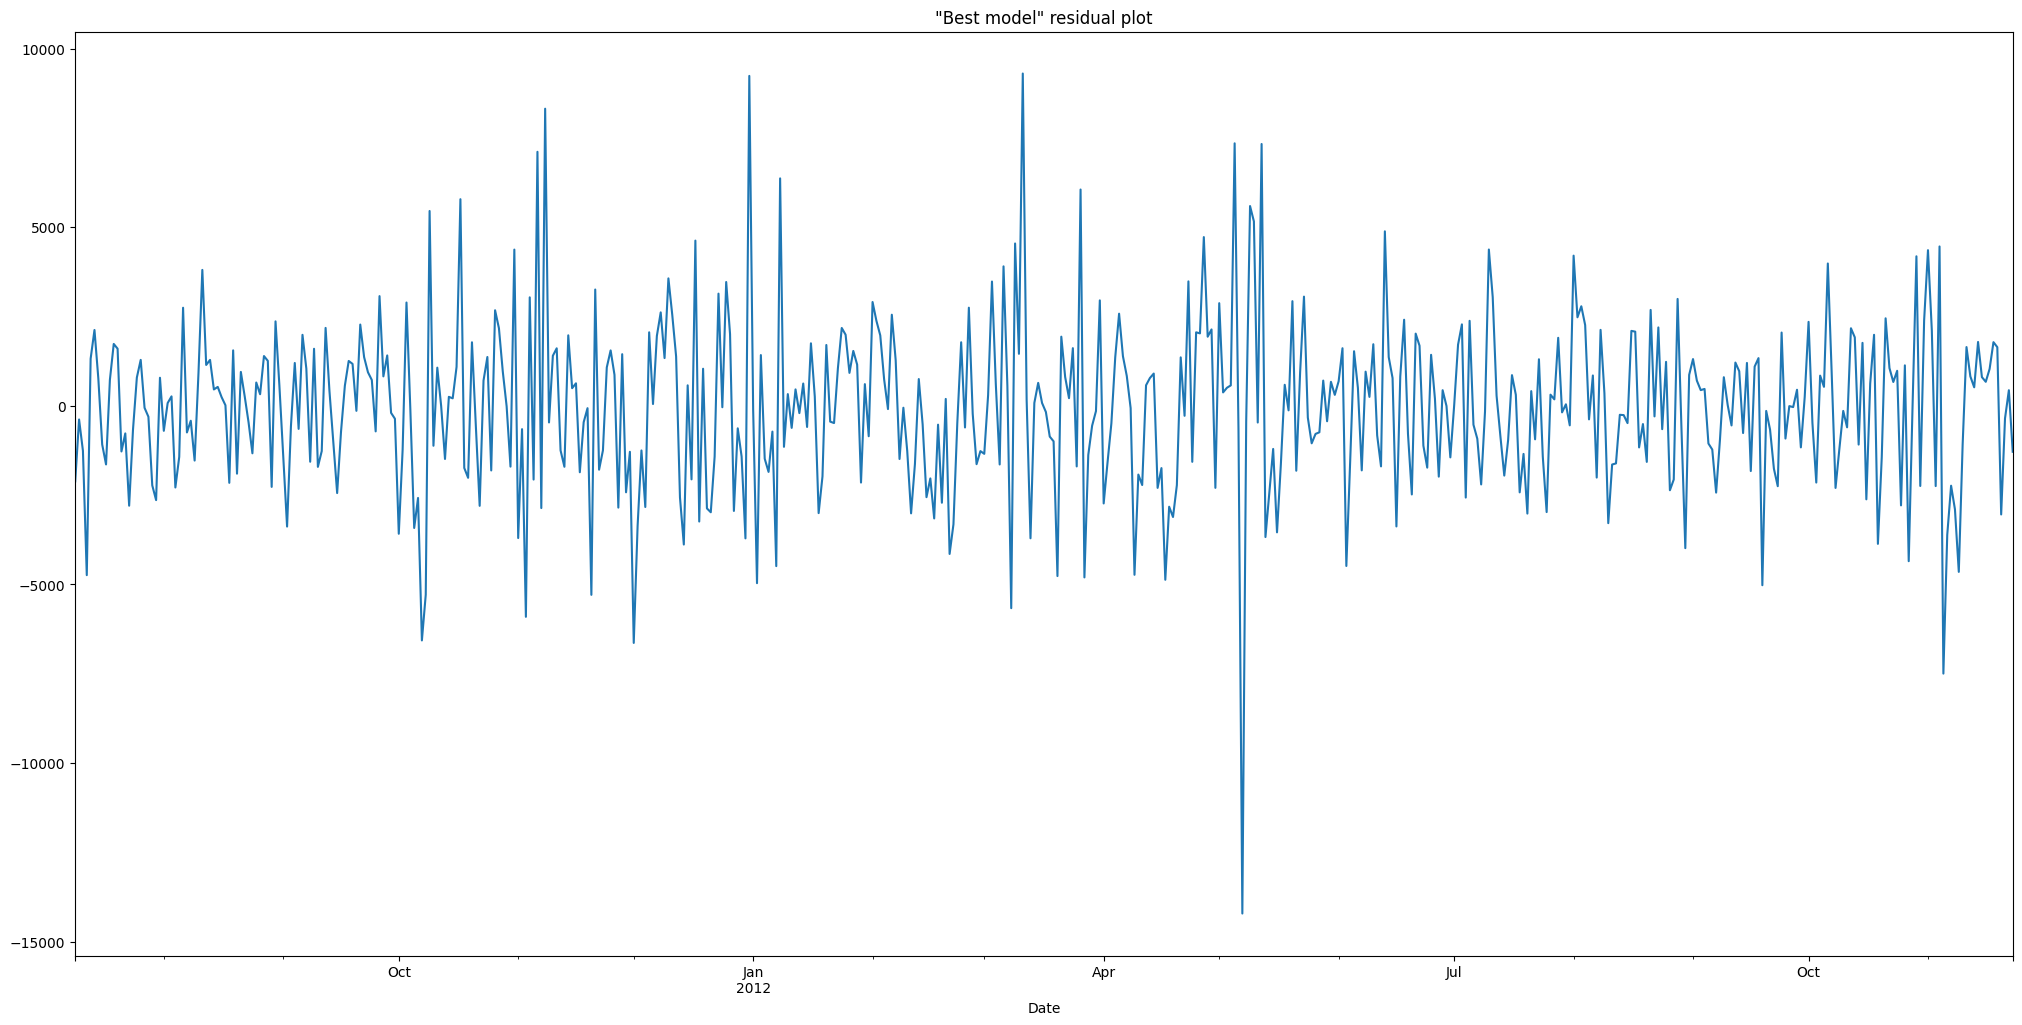

In [204]:
arima_best = arima_order_600_101
arima_best.resid.plot(figsize=[25,12])
plt.title("\"Best model\" residual plot")
plt.plot()

Let's run KPSS and ADF tests on the residuals of the best model.

In [205]:
kpss_test(arima_best.resid.values)

KPSS Statistic: 0.015388723467805537
p-value: 0.1
num lags: 3
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [206]:
adf_test(arima_best.resid)

ADF Statistic: -22.405669
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


Both tests show that the residuals are stationary.

In [207]:
# check residuals for auto-correlation

sm.stats.durbin_watson(arima_best.resid.values)

1.9980439681530835

Durbin-Watson statistic is very close to 2. So we can consider the residuals to be not autocorrelated.

In [208]:
# Wilcoxon test
# H0: residuals are unbiased (https://www.statisticshowto.com/wilcoxon-signed-rank-test)
stat, p = stats.wilcoxon(arima_best.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat, p))

Statistic: 61591.000000
pvalue: 0.53


Wilcoxon is almost 1/2 so we can consider the residuals to be unbiased (accept H0).

NormaltestResult(statistic=45.07647900883792, pvalue=1.6284219638034603e-10)


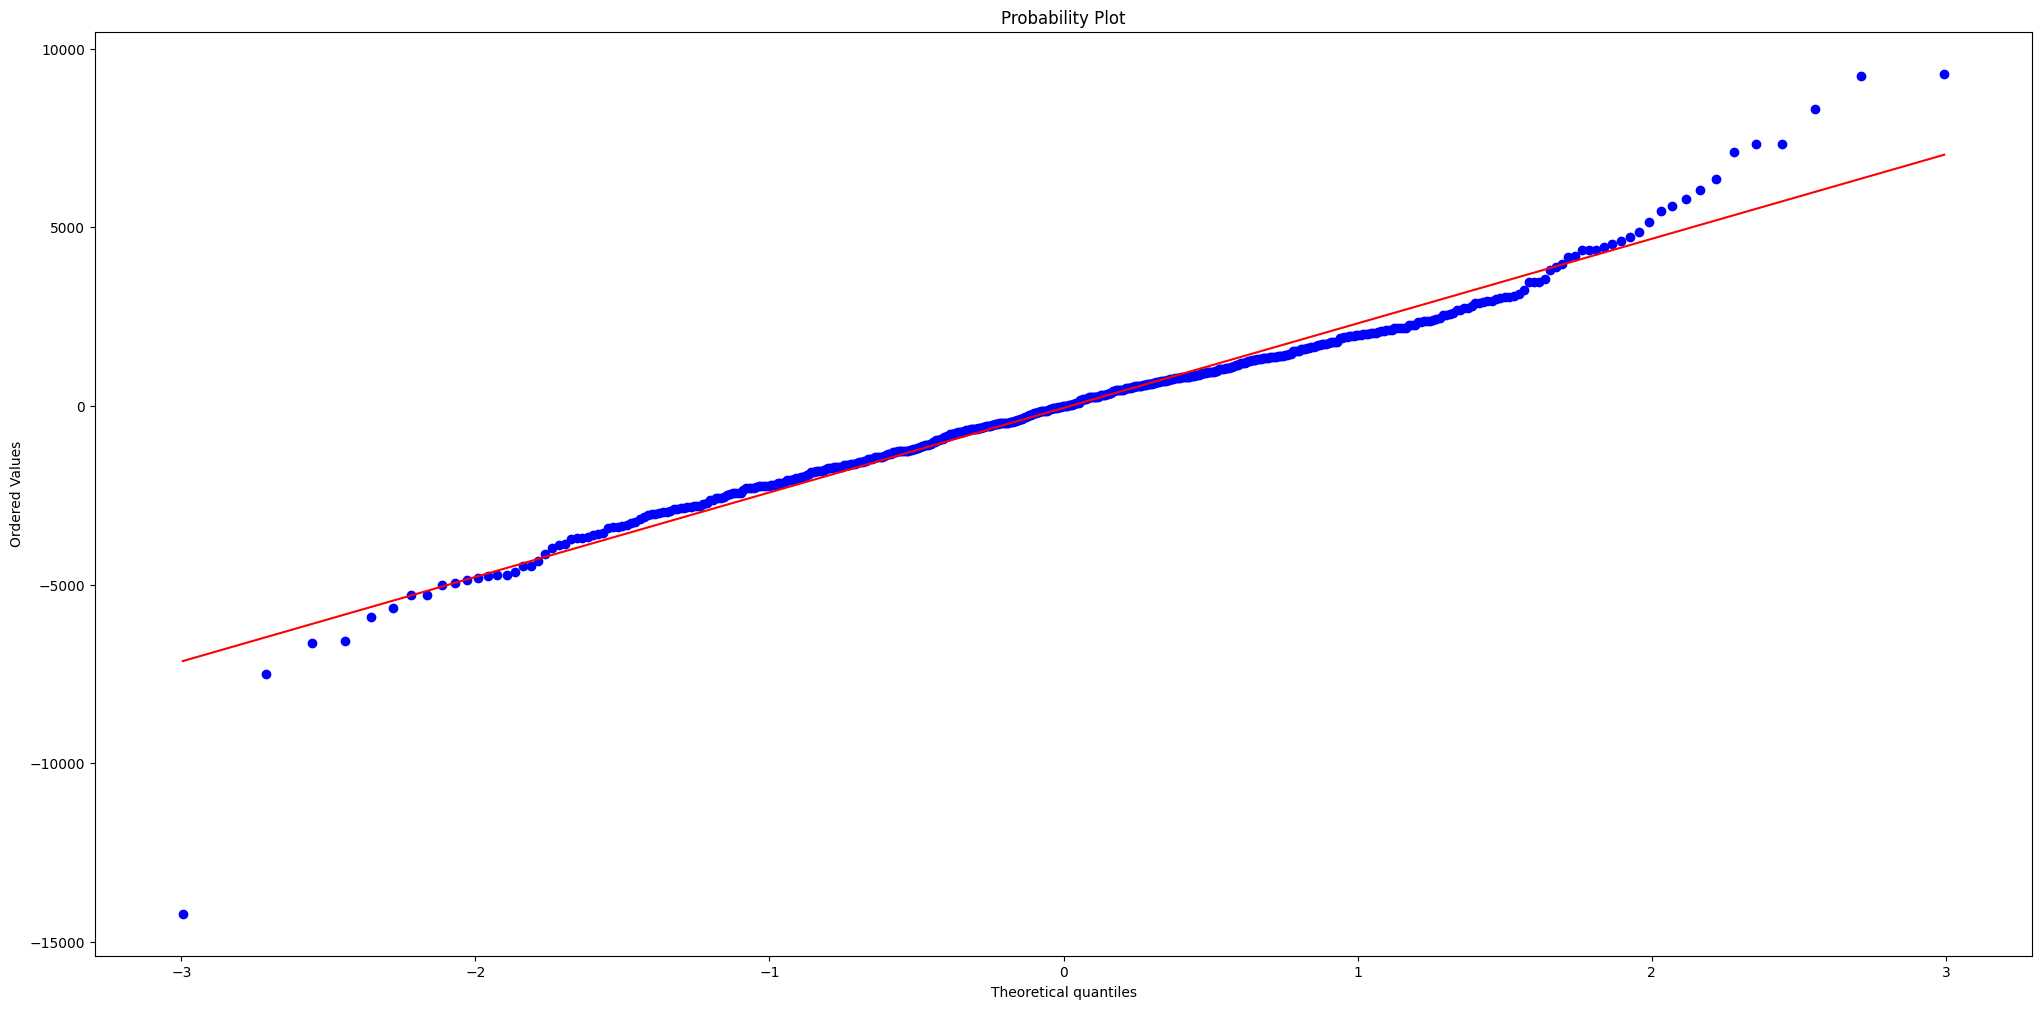

In [209]:
# Normality test
# H0: residuals are normally distributed
print(stats.normaltest(arima_best.resid))

plt.figure(figsize=[25,12])
res = stats.probplot(arima_best.resid, dist="norm", plot = plt)

Both normality test and Q-Q plot show that the residuals are not normally distributed.

We see that "Saturday" (0), "Sunday" (0), and "Temp1" (0.056) have low p-values. "Temp2" (0.671), on the other hand, can be dropped. So, let's rebuild the model without it.

C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:2979: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
C:\Users\grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site

                                          SARIMAX Results                                          
Dep. Variable:                           EnergyConsumption   No. Observations:                  512
Model:             SARIMAX([1, 2, 6], 0, 0)x(1, 0, [1], 7)   Log Likelihood                   0.000
Date:                                     Tue, 17 Jan 2023   AIC                             18.000
Time:                                             14:23:29   BIC                             56.145
Sample:                                         07-01-2011   HQIC                            32.953
                                              - 11-23-2012                                         
Covariance Type:                                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Saturday   -9077.1109         -0        in

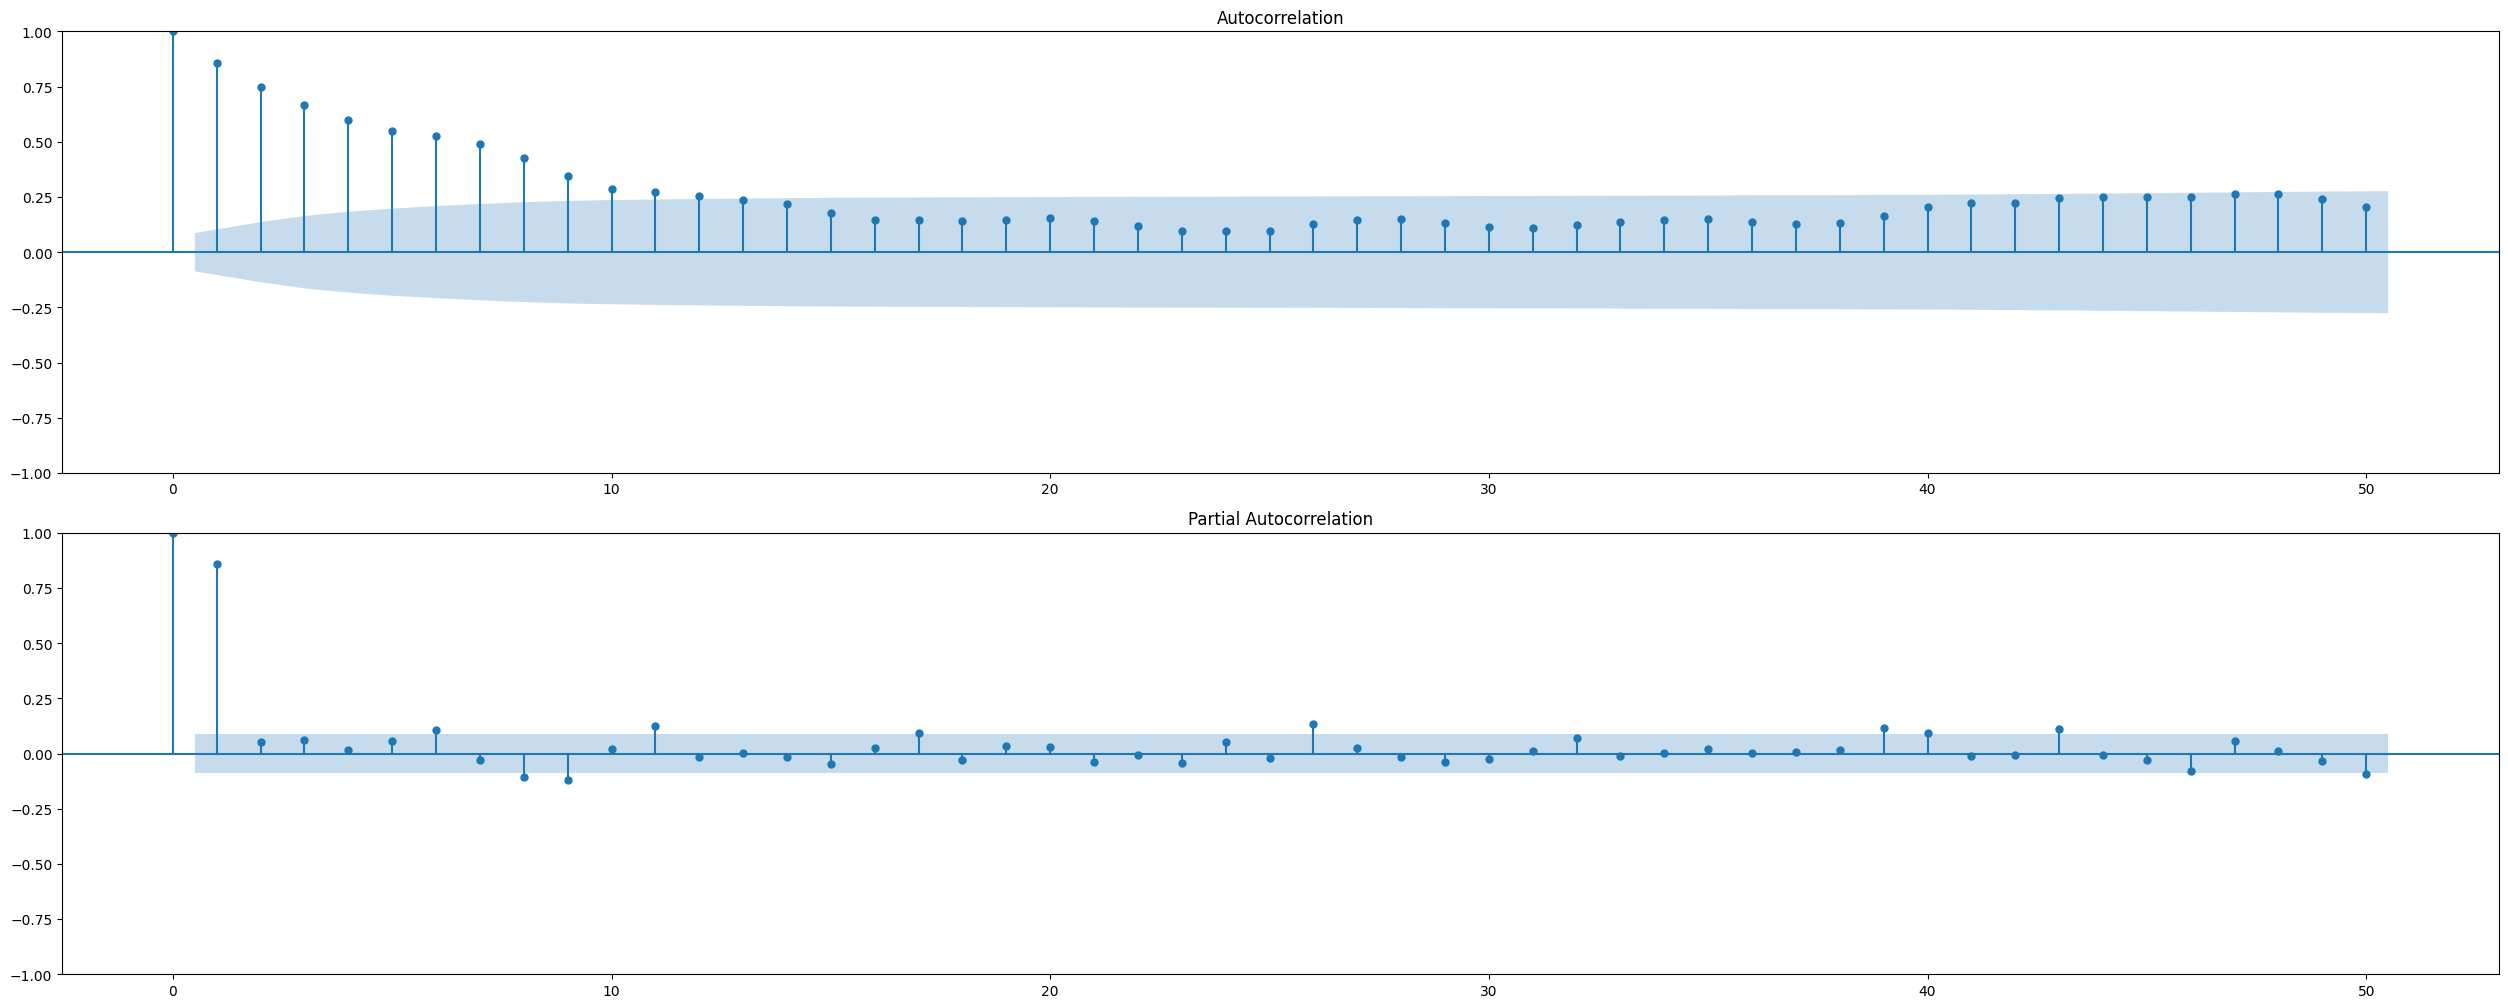

In [210]:
# Rebuild best model excluding insignificant regressors
# Use data differentiated w.r.t. yearly seasonality as SARIMAX can handle only 1 period
ts_sdiff_1 = ts_sdiff[:-len(ts2)]
endog = ts_sdiff_1['EnergyConsumption']
exogs = ts_sdiff_1[['Saturday', 'Sunday', 'Temp1']]
arima_best = sm.tsa.SARIMAX(endog=endog, order=[(1,2,6),0,0], seasonal_order=[1,0,1,7], exog=exogs).fit()
print(arima_best.summary())
plot_acf_pacf(arima_best, lags=50)

In [211]:
# Predict
ts_pred = arima_best.get_prediction()
ts_pred_ci = ts_pred.conf_int()

In [214]:
# Build forecast
ts_sdiff_2 = ts_sdiff[-len(ts2):]
exogs = ts_sdiff_2[['Saturday', 'Sunday', 'Temp1']]
ts_frc = arima_best.forecast(steps=len(ts_sdiff_2), exog=exogs)
ts_frc_int = (ts_frc + ts_original.shift(365)['EnergyConsumption']).iloc[-len(ts2):]

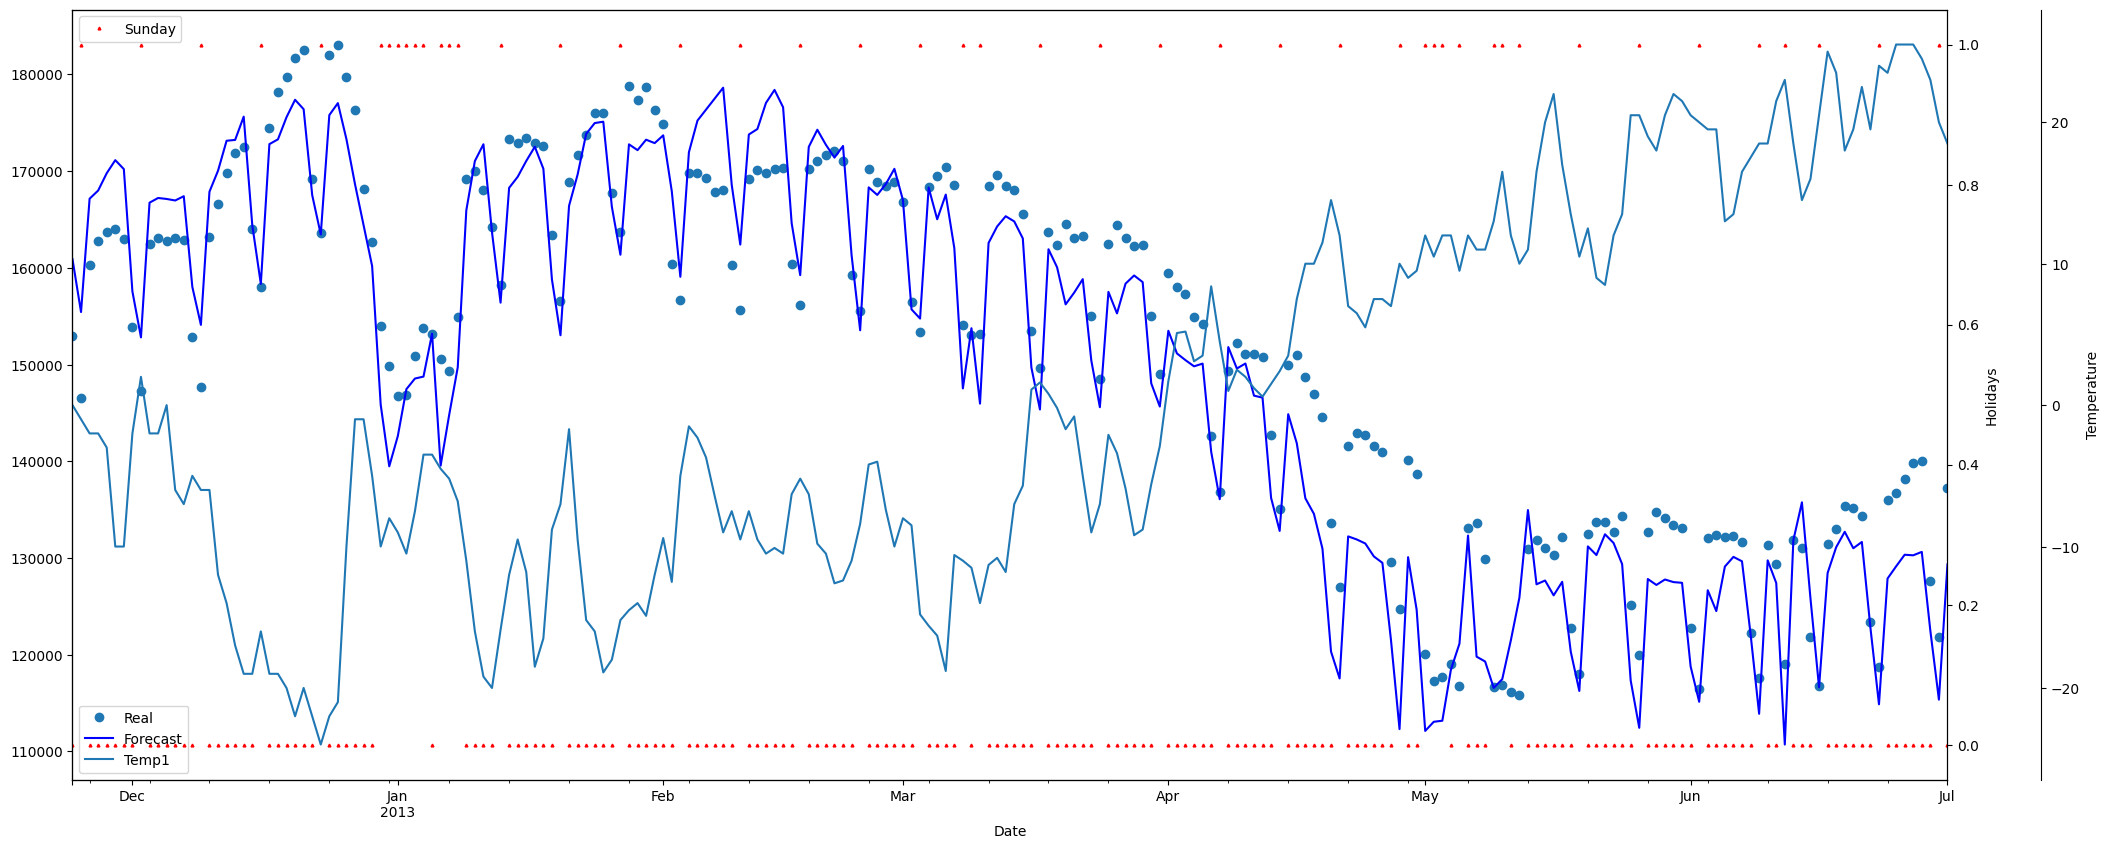

In [215]:
# Plot the TS together with independent variables
fig, ax = plt.subplots(figsize=[30,10])
ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
ax3.set_ylabel('Temperature')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.05))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.75)

ts2['EnergyConsumption'].plot(ax = ax,  style='o', label='Real')
ts_frc_int.plot(ax = ax,  style='b-', label='Forecast')
ts2[['Sunday']].plot(ax = ax2, style='r', marker = '^', markersize = 2.0, linewidth=0.0)

for col in exogs.columns:
    if col.startswith('Temp'):
        ts2[col].plot(ax = ax3)

lines = ax.get_lines() + ax3.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='lower left', ncol=1)
ax2.legend(loc='upper left')
plt.show()

In [216]:
# MAPE for the whole forecasting period
qualityMAPE(ts2['EnergyConsumption'], ts_frc_int)[0]

0.03154361571431638

The forecast shape looks appropriate in general but biased w.r.t. actual values. Also, MAPE is around 3%.

<h2 align="center">2. Find the best ARIMA Model automatically (30%) </h2>

* 0) define candidates for $p, d, q, P, D, Q$ values  
* 1) Run grid search for ARIMA parameters (use ts1 from the previous section) according to AIC|BIC|HQIC, feel free to use your own approach how to define the best model based on AIC|BIC|HQIC. How many time does it take to fit all ARIMA?
* 2) Run Residuals and Coefficint analysis for the best model
  - If all tests fail you need to rebuild automatically selected model (you can do it manually).
  - if there are some insignificant regressors that can be eliminated, please exclude them from the model.
* 3) build forecast for the ts2 (you need to transform exogenous variables if you applied Box-Cox tranformations in step 1); plot this forecast on the same plot with original ts2 data
* 4) Calculate loss MAPE of your forecast. Which model manually generated or automatically generated is better?

In [ ]:
# Put your code here

<h1 align="center"> Theoretical Bonus Part (Extra 50%)</h1>

<br></br>





**1. Let's consider simple AR model:** 
$$AR(p)\colon \;\;\; y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \varepsilon_t,$$  

where 
  - $y_t$ is a stationary time series with zero average,
  - $\phi_1,\dots,\phi_p$ are constants ($\phi_q \neq 0$), $~~$
  - $\varepsilon_t$ is gaussian white noise with zero average and constant dispersion $\sigma_\varepsilon^2.$
<br></br>
Proof that partial autocorrelation coefficients depend on $p$ and $\tau$ only:
   $$rr_{\tau} = {\bf{E}}[y_t-\hat y_t, y_{t+\tau} - \hat y_{t+\tau}]= \begin{cases}0 &, \tau>p; \\ f(\tau, p)>0 &, 1\leq\tau\leq p. \end{cases}$$
	
  where $\hat y_t$ - forecast of $y_t$ with following regression model $$y_t = \sum_{j=1}^{\tau-1}\beta_j y_{t+j}$$
  $\hat y_{t+\tau}$ - forecast of $y_{t+\tau}$ with following regression model $$y_{t+\tau} = \sum_{j=1}^{\tau-1}\gamma_j y_{t+j}.$$

<br></br>
<Answer>



**2. Let's consider simple MA model:**
  $$MA(q)\colon \;\;\; y_t = \varepsilon_t + \theta_1\varepsilon_{t-1} + \theta_2\varepsilon_{t-2} + \dots + \theta_q \varepsilon_{t-q},$$
  where 
  - $y_t$ is a stationary time series with zero average,$~~$
  - $\theta_1,\dots,\theta_q$ are constants ($\theta_q \neq 0$),$~~$ 
  - $\varepsilon_t$ is gaussian white noise with zero average and constant dispersion $\sigma_\varepsilon^2.$


Proof that the correlation coefficients depend on $\tau$ and $q$
$$r_\tau=\begin{cases}0 &, \tau>q; \\ f(\tau,q)>0 &, \tau\leq q. \end{cases}$$

<br></br>
<Answer>

**3. How to select candiates for $p$ and $q$ parameters for simple ARMA model based on ACF and PACF.**

<h1 align="center"> Practical Bonus Part (Extra 50%)</h1>

Realize method for searching optimal $\lambda$ for boxcox transformation.
Approach for finding the optimal $\lambda$ is descibed <a href="https://www.academia.edu/23049010/Time_series_analysis_supported_by_power_transformations">here</a>.  

You need to replace all 'TODO' below by some code:

In [ ]:
import numpy as np
class boxcox():
    def __init__(self, lmbda=None, shift=0):
        '''
    Box Cox Transforms
    Transforms data are to be normal. Also known as power transform.
    
    Parameters
        ----------
    lmbda: float or None
        lmbda the power parameter. The None input automatically calculates
        lmbda based on method guerrero
    shift: float
        Use to normalize data by shifting data to all positive values
        
        '''
        self.lmbda = lmbda
        self.shift = shift
        self.y = []
        self.method = 'guerrero'
        
    def transform(self, x, n=2):
        '''
            x: time series
            n: number of subseries with constant dispersion
        '''
        x = 1.0*np.asarray(x)
        
        if self.shift>0:
            x=  'TODO: shift time series up'
            
        if self.lmbda is None:
            self.lmbda = 'TODO: shift time series up'
            
        
            
        if self.lmbda == 0:
            self.y = 'TODO: '
        else:
            self.y = 'TODO: '
        return self.y, self.lmbda
        
    def optimal_lambda(self,x, n=2):
        """
        Parameters
        ----------
        x - time series with different variance through the time
        n - number of subseries in x, each subseries x_i has constant variance sigma_i and constant mean m_i
        The method states, that optimal lambda should be chosen in such a way that
         
         sigma_i/(m_i)**(1-lambda) = constant, for all i=1,...,n
        
        you need to find solution for the follow Regression problem:
        
        log(sigma_i) = w_1 + w_2*log(m_i), where
        w_2 = 1-lambda
        
        """
        x = 1.0*np.asarray(x)
               
        sigma = 'TODO: initialize array for log(sigma_i)'
        m = 'TODO: initialize array for matrix of regression [1, log(m_i)]'

        r = len(x)/n  # the length of each subseries

        for i in range(n):
            m[1][i] = 'TODO: fill matrix of regression'
            sigma[i] = 'TODO: fill array of sigma'

        # find the solution for regression Xw=y, where X = m, w[1] = 1-lambda, 
        w = np.dot(np.linalg.inv(np.dot(X,X.T)),np.dot(X,y))[1]
        
        self.lmbda = 'TODO: set value of lambda'
        
        print self.lmbda
        
        return self.lmbda

    def inverse(self, y=None):
        """
        Parameters
        ----------
        y: time series

        Returns
        -------
        x: inverse transformed ts
    
        """
        if y is None:
            y = self.y
        
        if self.lmbda == 0:
            x = 'TODO' 
        else:
            x = 'TODO'
        return x

In [ ]:
# Check on Wage data
# boxcox transformation for wage dataset 
ts_wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/33b78c9be63831567f8036ad40c5859e824d30f7/data/monthly-wage.csv', sep=';', decimal='.', parse_dates=True, index_col='Month')

In [ ]:
# cut first steps
ts_wage = ts_wage.ix['01.01.1999':'01.01.2017']
ts_wage.plot(figsize=(25,5))

In [ ]:
bc = boxcox()
ts_wage['wage_boxcox'], lmbda = bc.transform(ts_wage['Real wage'],n=18)
print ('lambda=', lmbda)
ts_wage['wage_boxcox'].plot(figsize=(15,5))